In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import hte vaedr functions we have created
from vidr import VIDR
from PCAEval import PCAEval
from utils import *

#Import important modules
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

#For calculating statistical distance
import geomloss
import pykeops
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_numpy_bindings()    # perform the compilation

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(dpi = 150, frameon = True)
sns.set_style("dark")
sc.settings.figdir = "../figures"

[KeOps] /mnt/home/kanaomar/.cache/keops2.1.1/build_CUDA_VISIBLE_DEVICES_0_1_2_3 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
[KeOps] Generating code for formula Sum_Reduction((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)),1) ... OK
pyKeOps with numpy bindings is working!


In [2]:
adata = sc.read_h5ad("../data/train_species.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 62114 × 6619
    obs: 'condition', 'species', 'individual', 'batch', 'louvain', 'n_counts'
    var: 'gene_ids-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-2-0-0-0', 'gene_ids-0-1-0-0', 'gene_ids-1-1-0-0', 'gene_ids-2-1-0-0', 'gene_ids-0-0-1-0', 'gene_ids-1-0-1-0', 'gene_ids-2-0-1-0', 'gene_ids-0-1-1-0', 'gene_ids-1-1-1-0', 'gene_ids-2-1-1-0', 'gene_ids-3-1-1-0', 'gene_ids-0-0-0-1', 'gene_ids-1-0-0-1', 'gene_ids-2-0-0-1', 'gene_ids-0-1-0-1', 'gene_ids-1-1-0-1', 'gene_ids-2-1-0-1', 'gene_ids-0-0-1-1', 'gene_ids-1-0-1-1', 'gene_ids-2-0-1-1', 'gene_ids-0-1-1-1', 'gene_ids-1-1-1-1', 'gene_ids-2-1-1-1'
    uns: 'condition_colors', 'neighbors', 'species_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [4]:
adata.obs.species

index
AAACCTGTCGGTCTAA-1-0-0-0-0    rabbit
AAACCTGTCTGTCCGT-1-0-0-0-0    rabbit
AAACGGGAGCCGATTT-1-0-0-0-0    rabbit
AAACGGGAGGCGCTCT-1-0-0-0-0    rabbit
AAACGGGCACAACGCC-1-0-0-0-0    rabbit
                               ...  
TTTGGTTGTGGGTATG-1-2-1-1-1     mouse
TTTGTCAAGCCCTAAT-1-2-1-1-1     mouse
TTTGTCAAGCTAAACA-1-2-1-1-1     mouse
TTTGTCACAGTTTACG-1-2-1-1-1     mouse
TTTGTCATCCGTTGTC-1-2-1-1-1     mouse
Name: species, Length: 62114, dtype: category
Categories (4, object): ['mouse', 'pig', 'rabbit', 'rat']

In [5]:
# #Training model
# for cell in ["rat", "rabbit", "pig"]:
#     train_adata, test_adata = prepare_data(adata, "species", "condition", cell, "LPS6", normalized = True)
#     vae = VIDR(train_adata, linear_decoder = False)

#     vae.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)
#     vae.save(f"../../data/VAE_Species_Prediction_LPS_7000g_{cell}.pt", overwrite = True)

In [6]:
cell = "rat"
train_adata, test_adata = prepare_data(adata, "species", "condition", cell, "LPS6", normalized = True)
vae = VIDR(train_adata, linear_decoder = False)
vae = vae.load(f"../../data/VAE_Species_Prediction_LPS_7000g_{cell}.pt/", train_adata)

INFO     Using batches from adata.obs["condition"]                                                                 
INFO     Using labels from adata.obs["species"]                                                                    
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 52691 cells, 6619 vars, 2 batches, 4 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
None
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                    

In [8]:
jaccard_similarity = lambda x, y: len(set(x) & set(y))/len(set(x) | set(y)) 

In [12]:
C = adata.obs.species.unique().shape[0]
jaccard_mat = np.zeros([C,C])
all_cts = adata.obs.species.unique()

for idx, cell_i in enumerate(all_cts):
    CD4T = adata[adata.obs["species"] ==cell_i]
    sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
    diff_genes_i = CD4T.uns["rank_genes_groups"]["names"]["LPS6"][:100]
    for jdx, cell_j in enumerate(all_cts):
        print(cell_i, cell_j)
        CD4T = adata[adata.obs["species"] ==cell_j]
        sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
        diff_genes_j = CD4T.uns["rank_genes_groups"]["names"]["LPS6"][:100]
        
        sim = jaccard_similarity(diff_genes_i, diff_genes_j)
        jaccard_mat[idx, jdx] = sim

rabbit rabbit
rabbit pig
rabbit rat
rabbit mouse
pig rabbit
pig pig
pig rat
pig mouse
rat rabbit
rat pig
rat rat
rat mouse
mouse rabbit
mouse pig
mouse rat
mouse mouse


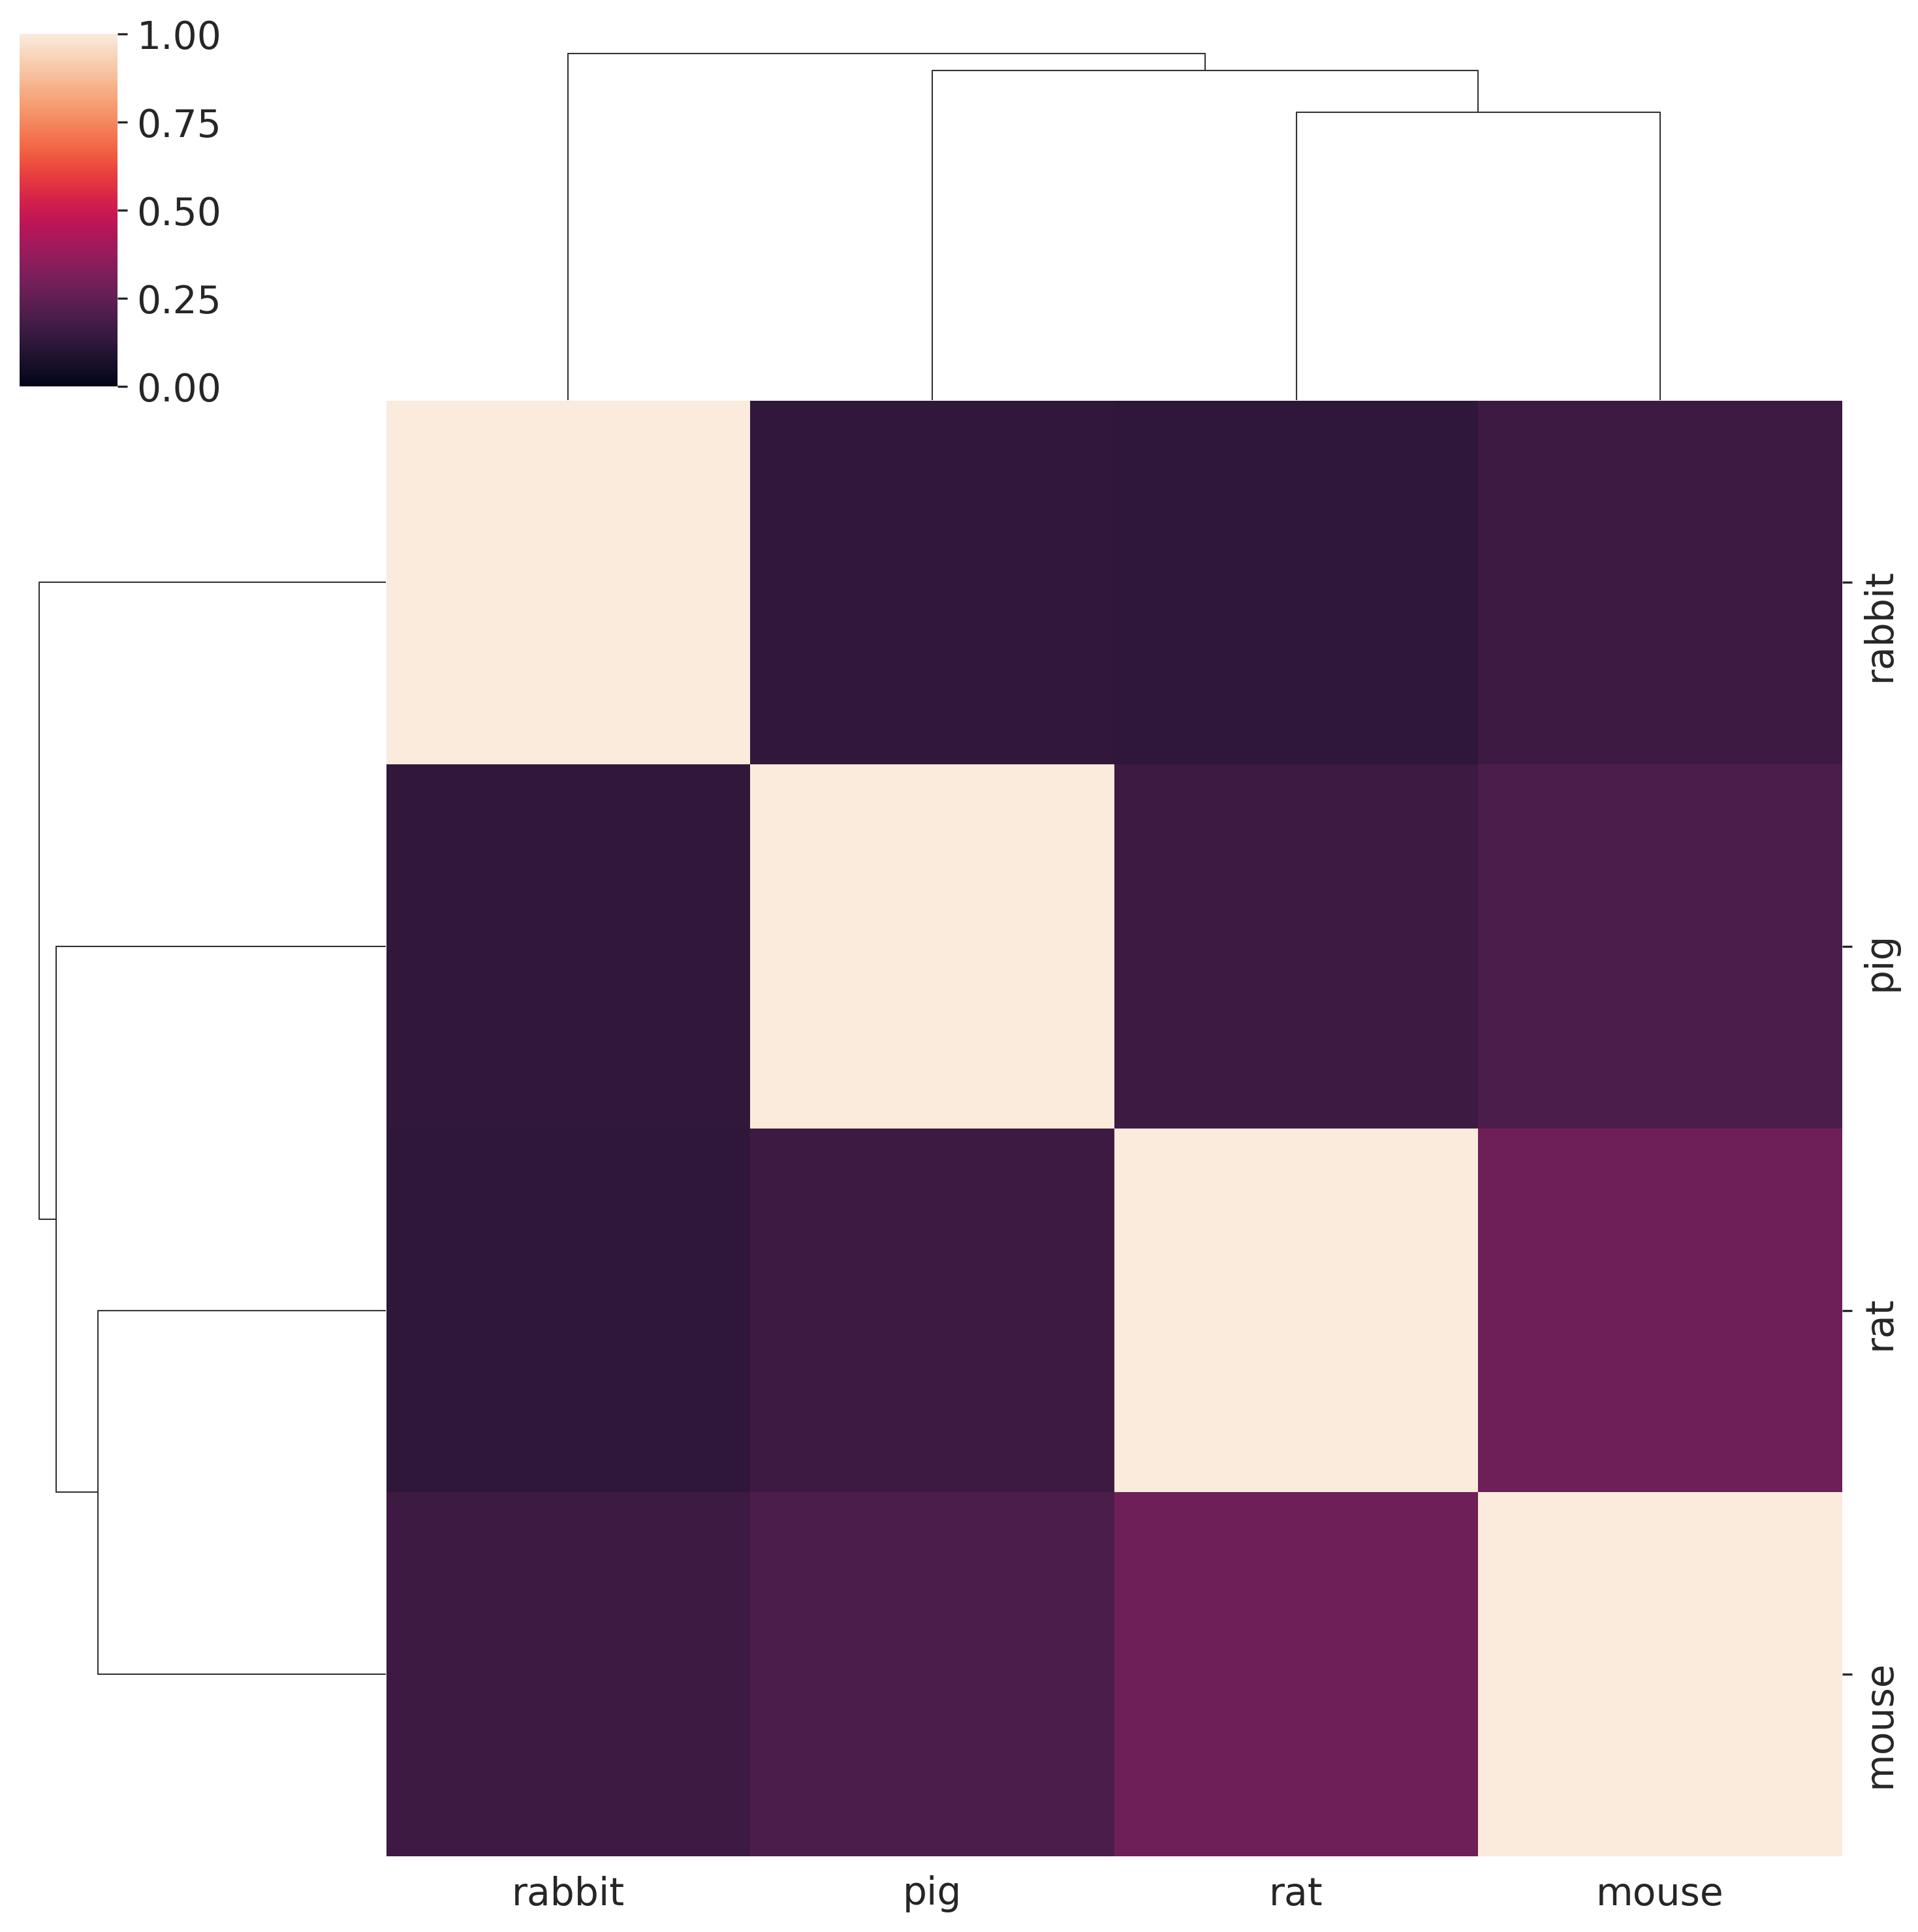

In [13]:
sns.clustermap(data = jaccard_mat, xticklabels = all_cts, yticklabels = all_cts, vmin = 0)

In [14]:
jaccard_list = []

for idx, cell_i in enumerate(all_cts):
    CD4T = adata[adata.obs["species"] ==cell_i]
    sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
    diff_genes_i = CD4T.uns["rank_genes_groups"]["names"]["LPS6"][:100]
    for jdx, cell_j in enumerate(all_cts):
        print(cell_i, cell_j)
        CD4T = adata[adata.obs["species"] ==cell_j]
        sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
        diff_genes_j = CD4T.uns["rank_genes_groups"]["names"]["LPS6"][:100]
        
        sim = jaccard_similarity(diff_genes_i, diff_genes_j)
        jaccard_list.append([cell_i, cell_j, sim])
        

rabbit rabbit
rabbit pig
rabbit rat
rabbit mouse
pig rabbit
pig pig
pig rat
pig mouse
rat rabbit
rat pig
rat rat
rat mouse
mouse rabbit
mouse pig
mouse rat
mouse mouse


In [15]:
jaccard_df_narrow = pd.DataFrame(jaccard_list, columns = ["Cell Type", "Cell B", "Jaccard Similarity"])

In [16]:
filt_df = jaccard_df_narrow[jaccard_df_narrow["Jaccard Similarity"] != 1]

Text(0.5, 0, 'Species')

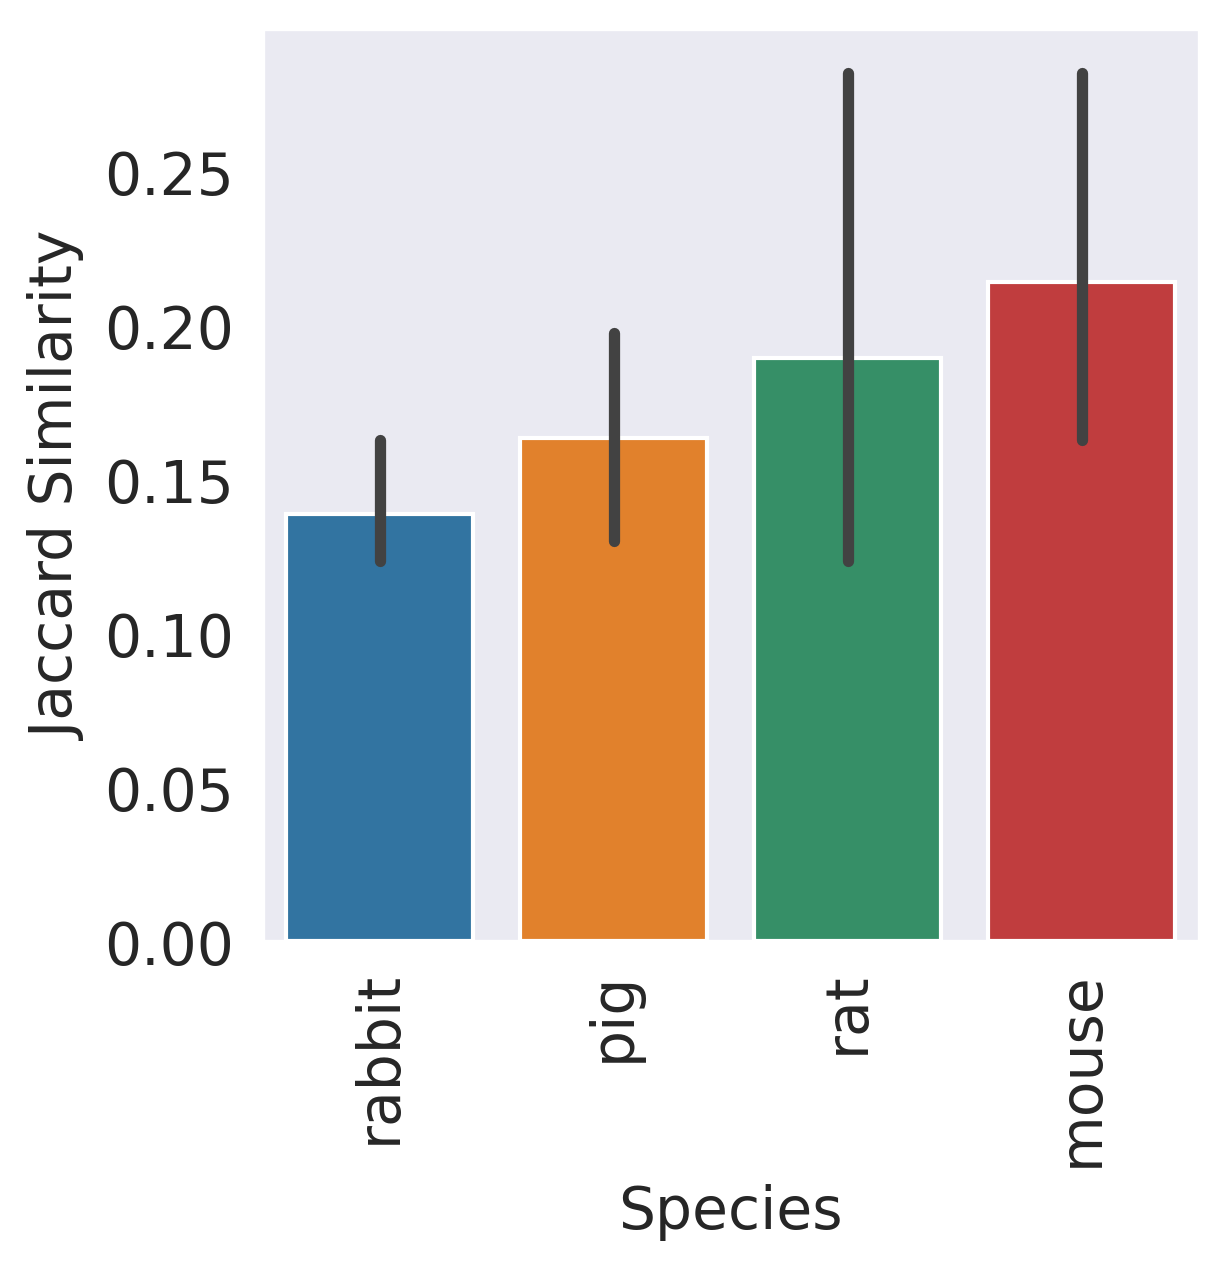

In [17]:
sns.barplot(x = "Cell Type", y = "Jaccard Similarity", data = filt_df)
plt.xticks(rotation = 90)
plt.xlabel("Species")

In [6]:
#UMAP Projection of latent space
latent_X = vae.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 62114 cells, 6619 vars, 2 batches, 4 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


In [8]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [9]:
latent_adata.obs["Training Split"] =  ["Test" if ((i == "rat") & (j == "LPS6")) else "Train" for i, j in zip(latent_adata.obs["species"], latent_adata.obs["condition"])]

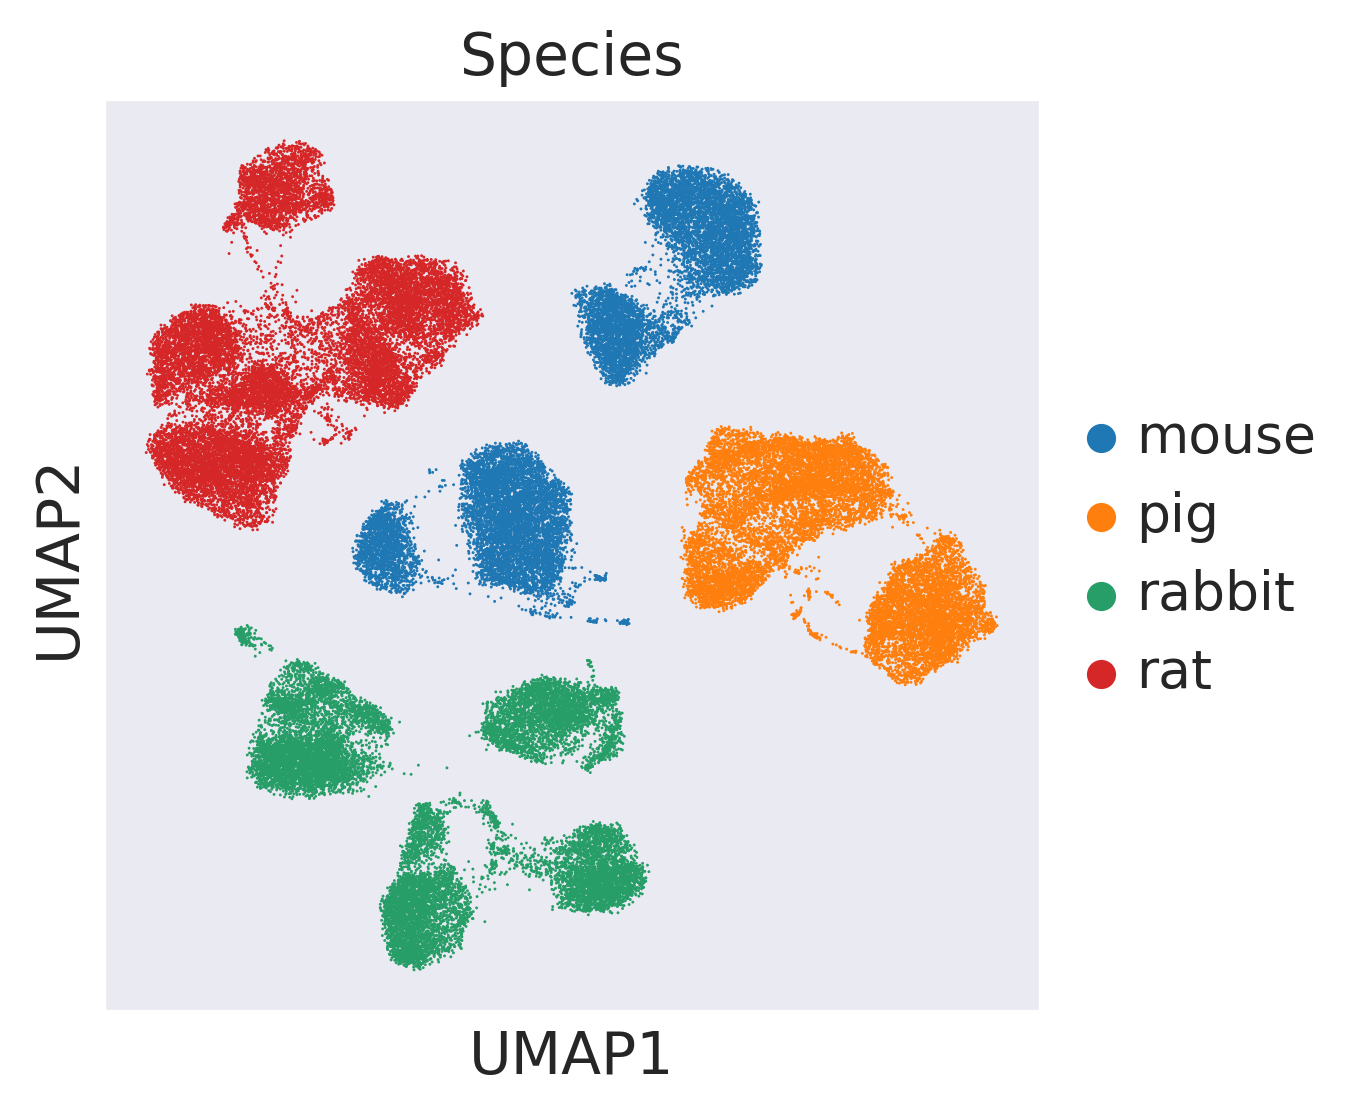

In [10]:
ax = sc.pl.umap(
    latent_adata,
    color = ["species"],
    wspace = 0.45,
    title = "Species"
)

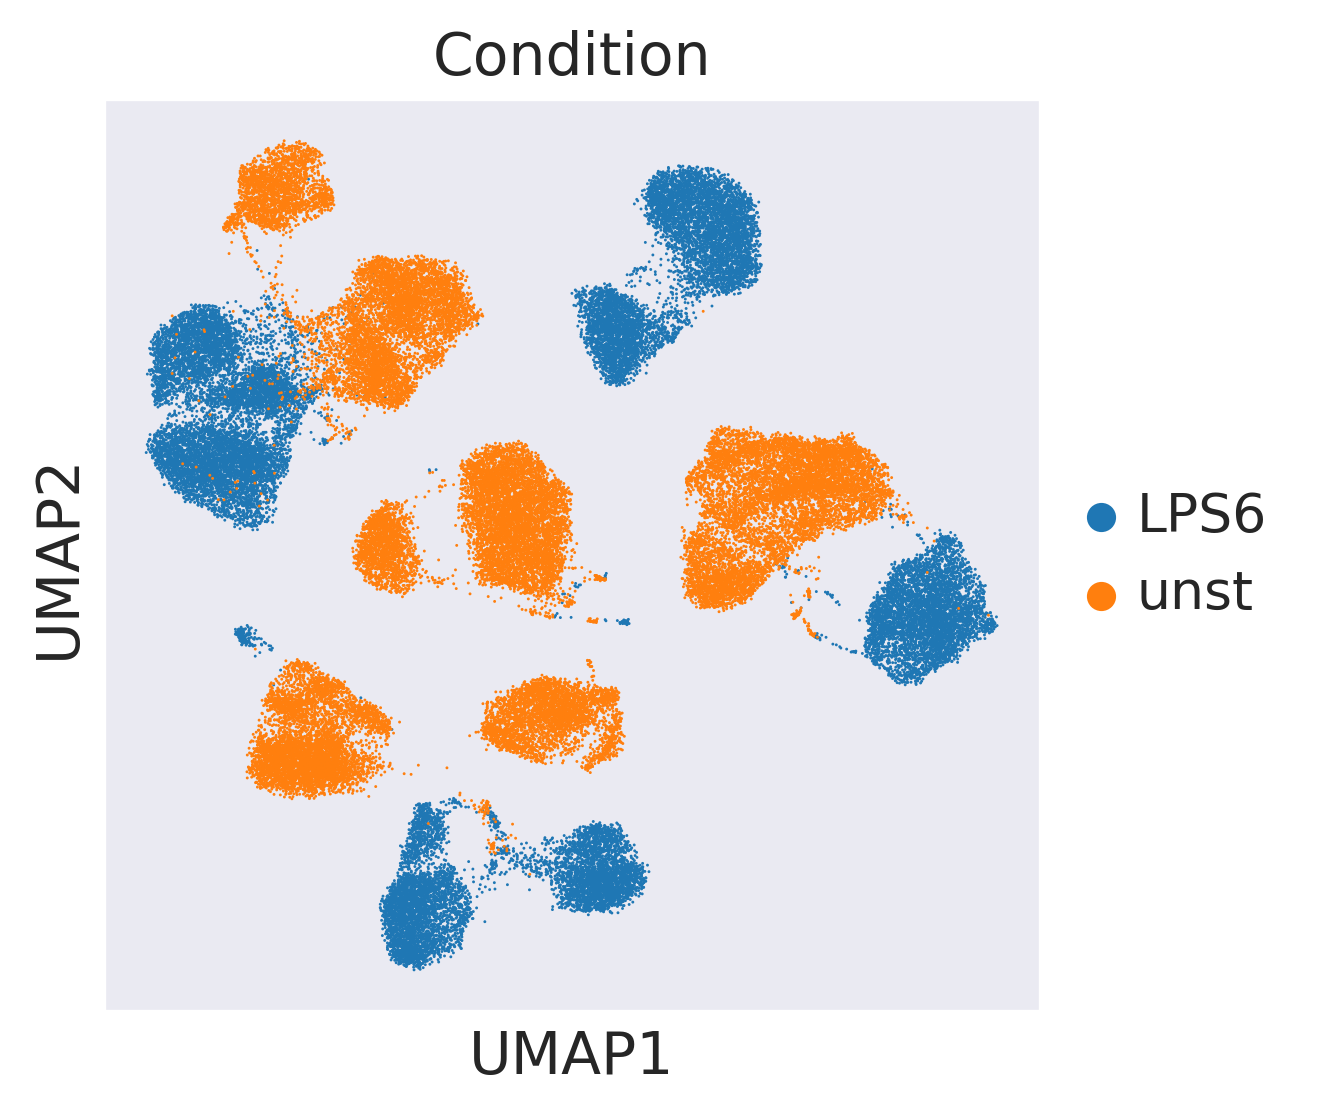

In [11]:
ax = sc.pl.umap(
    latent_adata,
    color = ["condition"],
    wspace = 0.45,
    title = "Condition"
)

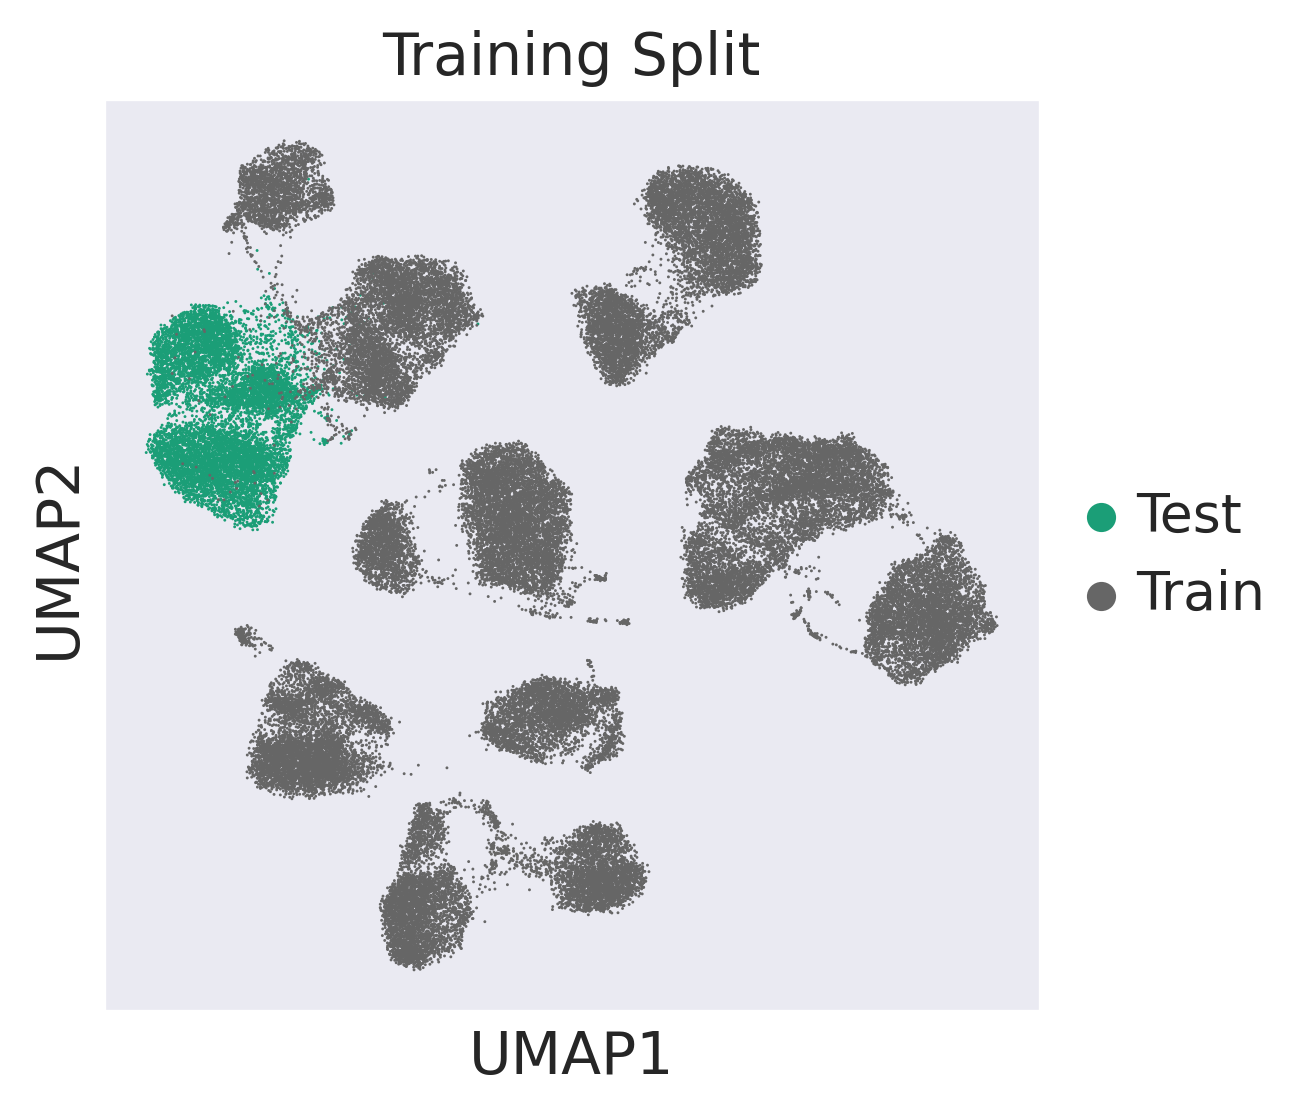

In [12]:
ax = sc.pl.umap(
    latent_adata,
    color = ["Training Split"],
    palette = "Dark2",
    wspace = 0.45
)

In [7]:
ctrl_key = "unst"
treat_key = "LPS6"
cell_type_to_predict = "rat"

In [8]:
cell_type_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_labels"][
    "original_key"
]
treatment_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_batch"][
    "original_key"
]

In [9]:
vae.adata.obs["species_condition"] = adata.obs.species.astype(str) + adata.obs.condition.astype(str)

In [10]:
adata_bal = random_sample(vae.adata, "species_condition", "min")
adata_bal_ctrl = adata_bal[(adata_bal.obs[cell_type_key] == cell_type_to_predict) & (adata_bal.obs[treatment_key] == ctrl_key)]
latent_bal =  vae.get_latent_representation(adata_bal)
latent_bal_adata = sc.AnnData(X=latent_bal, obs = adata_bal.obs.copy())
latent_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_type_to_predict) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X

In [17]:
#Get deltas and control centroids for each cell tpye in the training dataset
deltas = []
latent_centroids = []
cell_types = np.unique(latent_adata.obs[cell_type_key])
for cell_i in cell_types:
    if cell_i != cell_type_to_predict:
        latent_ctrl = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
        latent_treat = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == treat_key)].X
        deltas_i = np.average(latent_treat, axis = 0) - np.average(latent_ctrl, axis = 0)
        deltas.append(deltas_i)
        latent_centroids.append(np.average(latent_ctrl, axis = 0))
lr = LinearRegression()
reg = lr.fit(latent_centroids, deltas)
scvidr_delta = reg.predict([np.average(latent_cd, axis = 0)])[0]

### scVIDR Rat Results

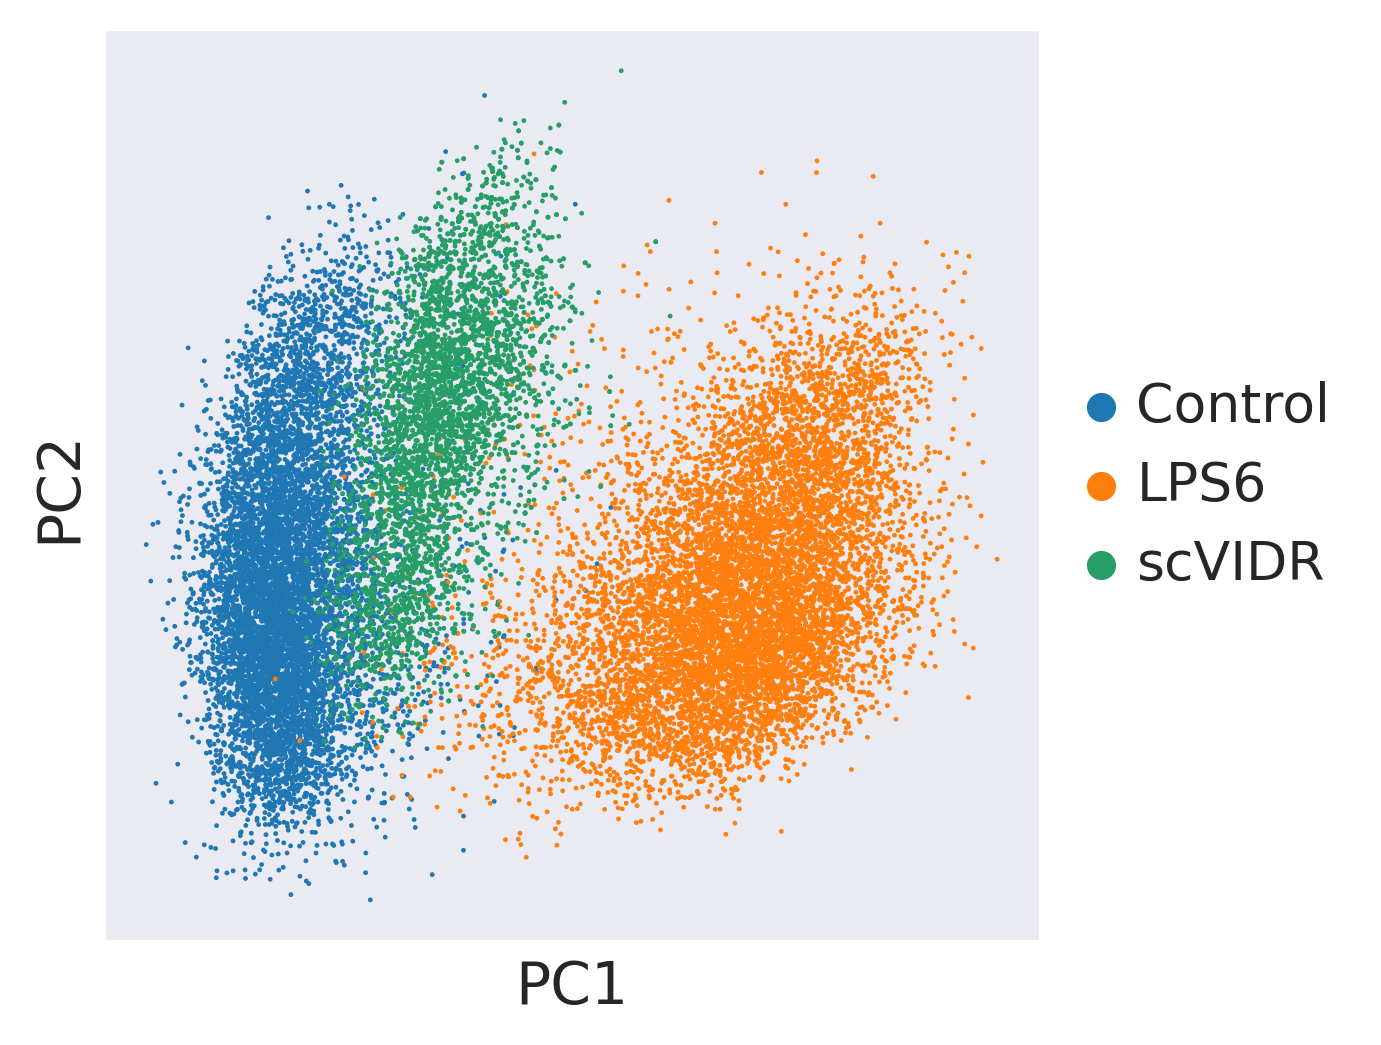

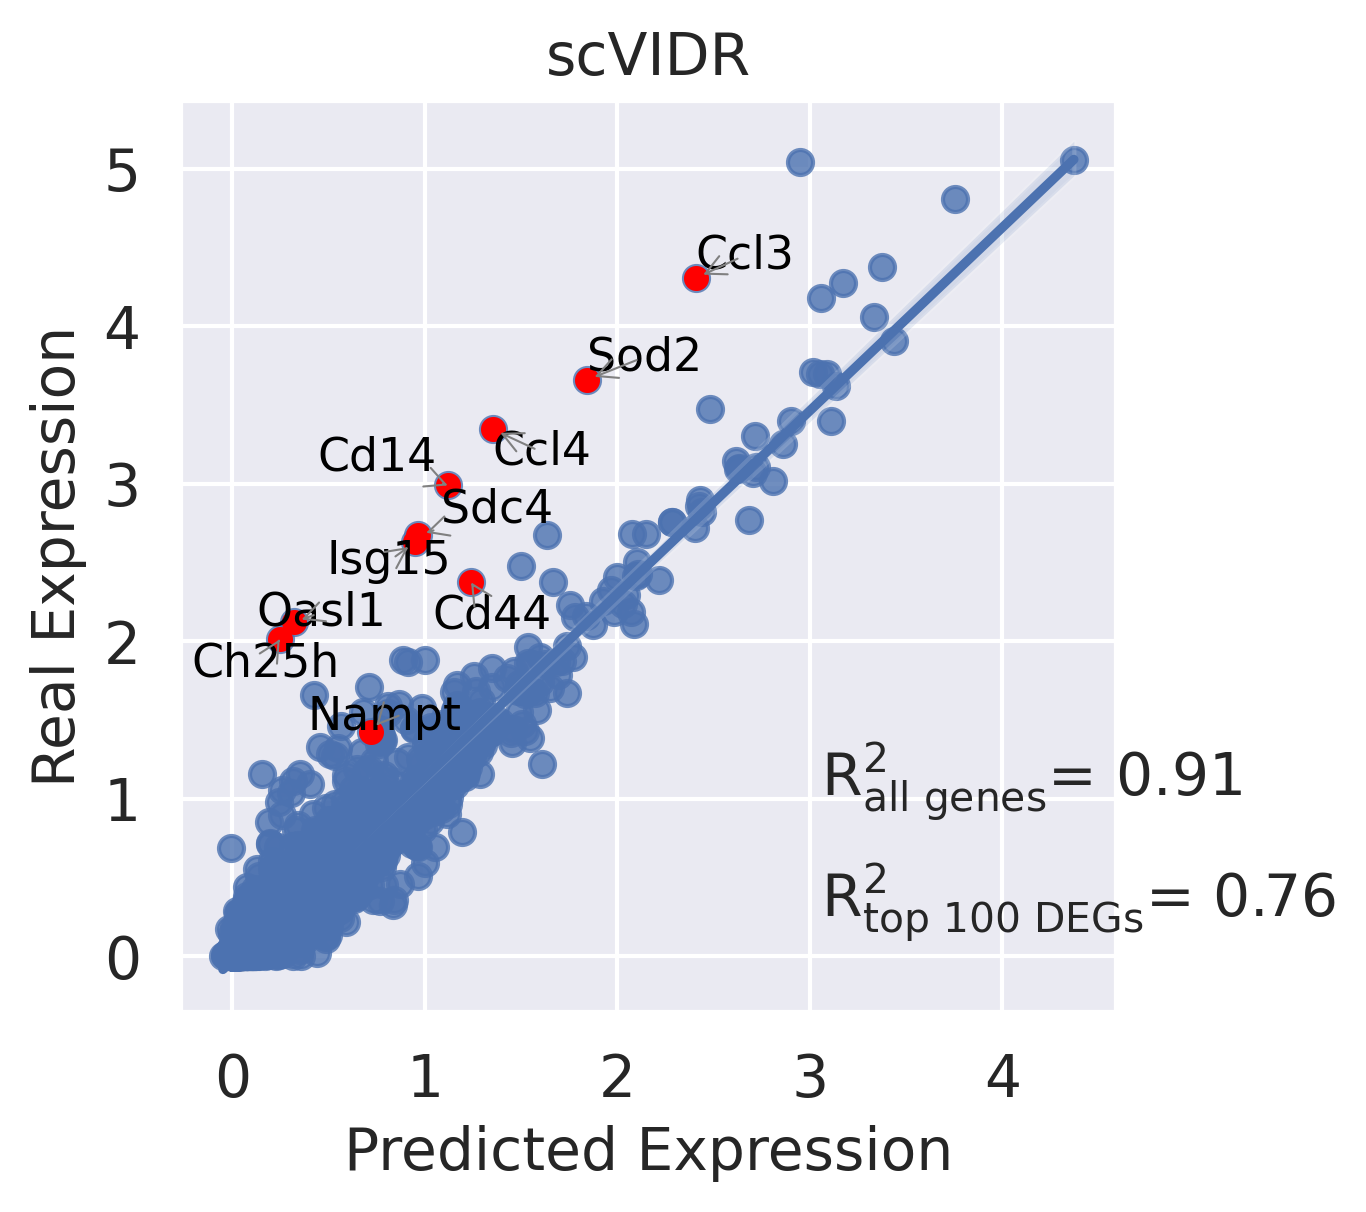

In [18]:
treat_pred = scvidr_delta + latent_cd
predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
pred.obs["condition"] = 'pred'
ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata2.obs["condition"]:
    if i == 'unst':
        treatments.append("Control")
    elif i == "LPS6":
        treatments.append("LPS6")
    else:
        treatments.append("scVIDR")
eval_adata2.obs["Treatment"] = treatments
sc.tl.pca(eval_adata2)
sc.pl.pca(eval_adata2, color = "Treatment", frameon = True, title = "", save = "SF8B1.svg")
CD4T = adata[adata.obs["species"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["LPS6"]
r2_value = vae.reg_mean_plot(
eval_adata2,
axis_keys={"x": "pred", "y": "LPS6"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF8C1.svg",
show=True,
legend=False, title = "scVIDR")

### scGen Cross Species Results

In [19]:
latent_mouse_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == "mouse") & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
latent_mouse_trt = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == "mouse") & (latent_bal_adata.obs[treatment_key] == treat_key)].X

scgen_treat_delta = np.average(latent_mouse_trt,axis=0) - np.average(latent_mouse_cd,axis=0)
scgen_species_delta = np.average(latent_cd,axis=0) - np.average(latent_mouse_cd,axis=0)

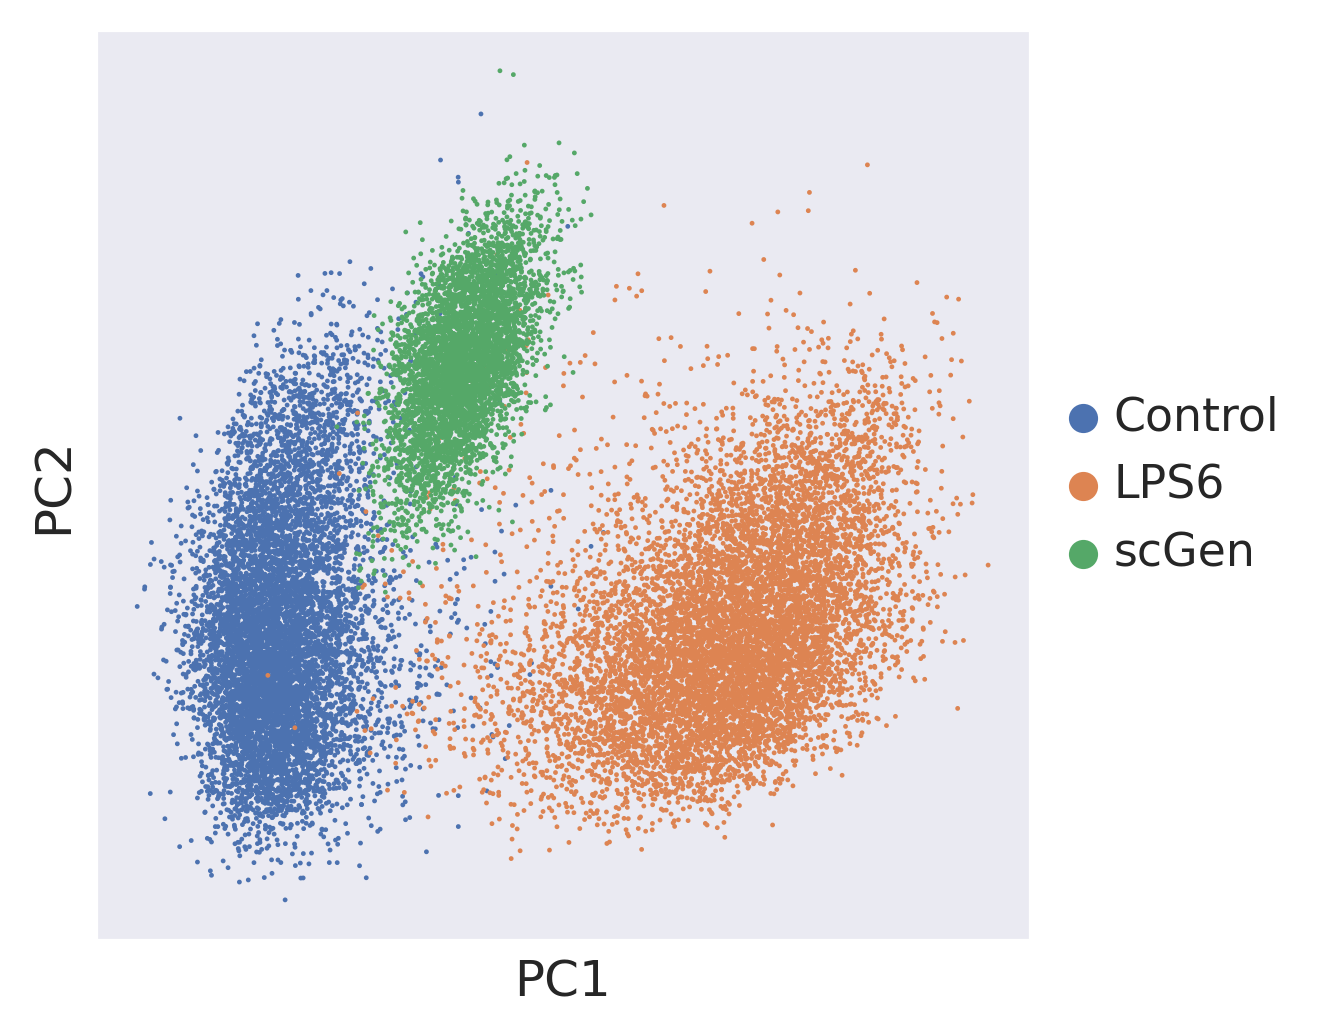

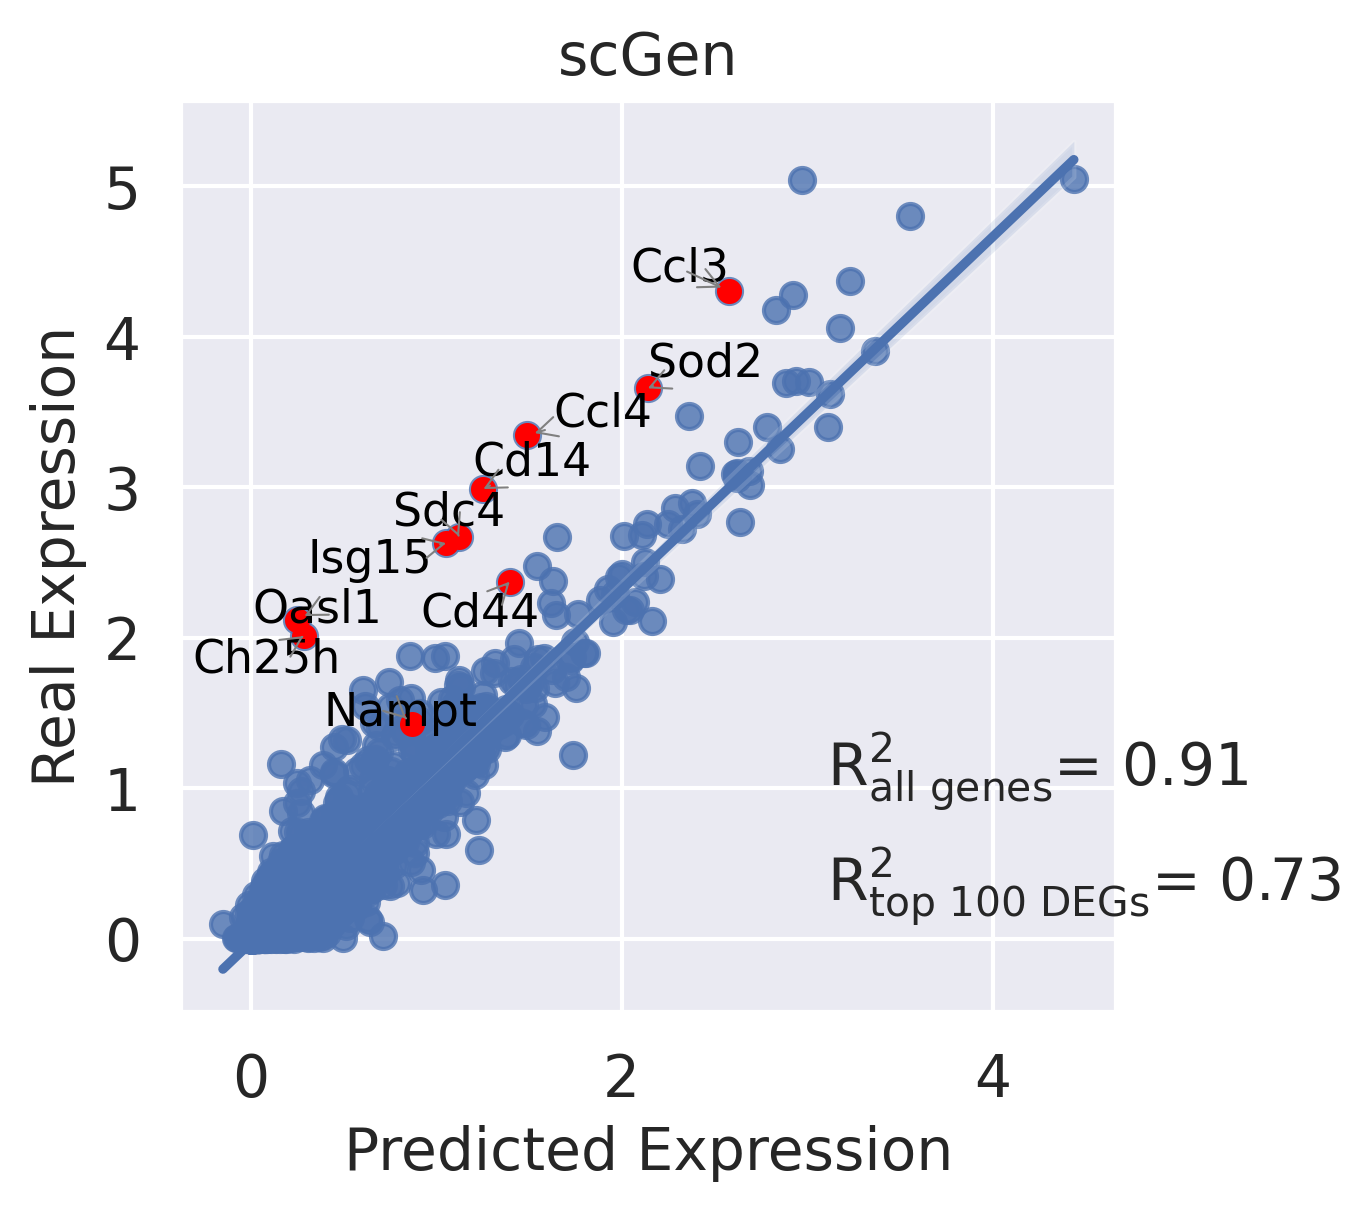

In [20]:
treat_pred = 0.5*(scgen_species_delta + latent_mouse_trt + scgen_treat_delta + latent_cd)
predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
pred.obs["condition"] = 'pred'
ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata2.obs["condition"]:
    if i == 'unst':
        treatments.append("Control")
    elif i == "LPS6":
        treatments.append("LPS6")
    else:
        treatments.append("scGen")
eval_adata2.obs["Treatment"] = treatments
sc.tl.pca(eval_adata2)
sc.pl.pca(eval_adata2, color = "Treatment", frameon = True, title = "", save = "SF8B2.svg")
CD4T = adata[adata.obs["species"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["LPS6"]
r2_value = vae.reg_mean_plot(
eval_adata2,
axis_keys={"x": "pred", "y": "LPS6"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF8C2.svg",
show=True,
legend=False, title = "scGen")

## scGen Results with Average Delta

In [21]:
latent_ctrl = latent_bal_adata[(latent_bal_adata.obs[treatment_key] == ctrl_key)].X
latent_treat = latent_bal_adata[(latent_bal_adata.obs[treatment_key] == treat_key)].X
scgen_delta = np.average(latent_treat, axis = 0) - np.average(latent_ctrl, axis = 0)

In [22]:
# latent_bal_adata[(latent_bal_adata.obs[treatment_key] == treat_key)].obs.species_condition.unique()

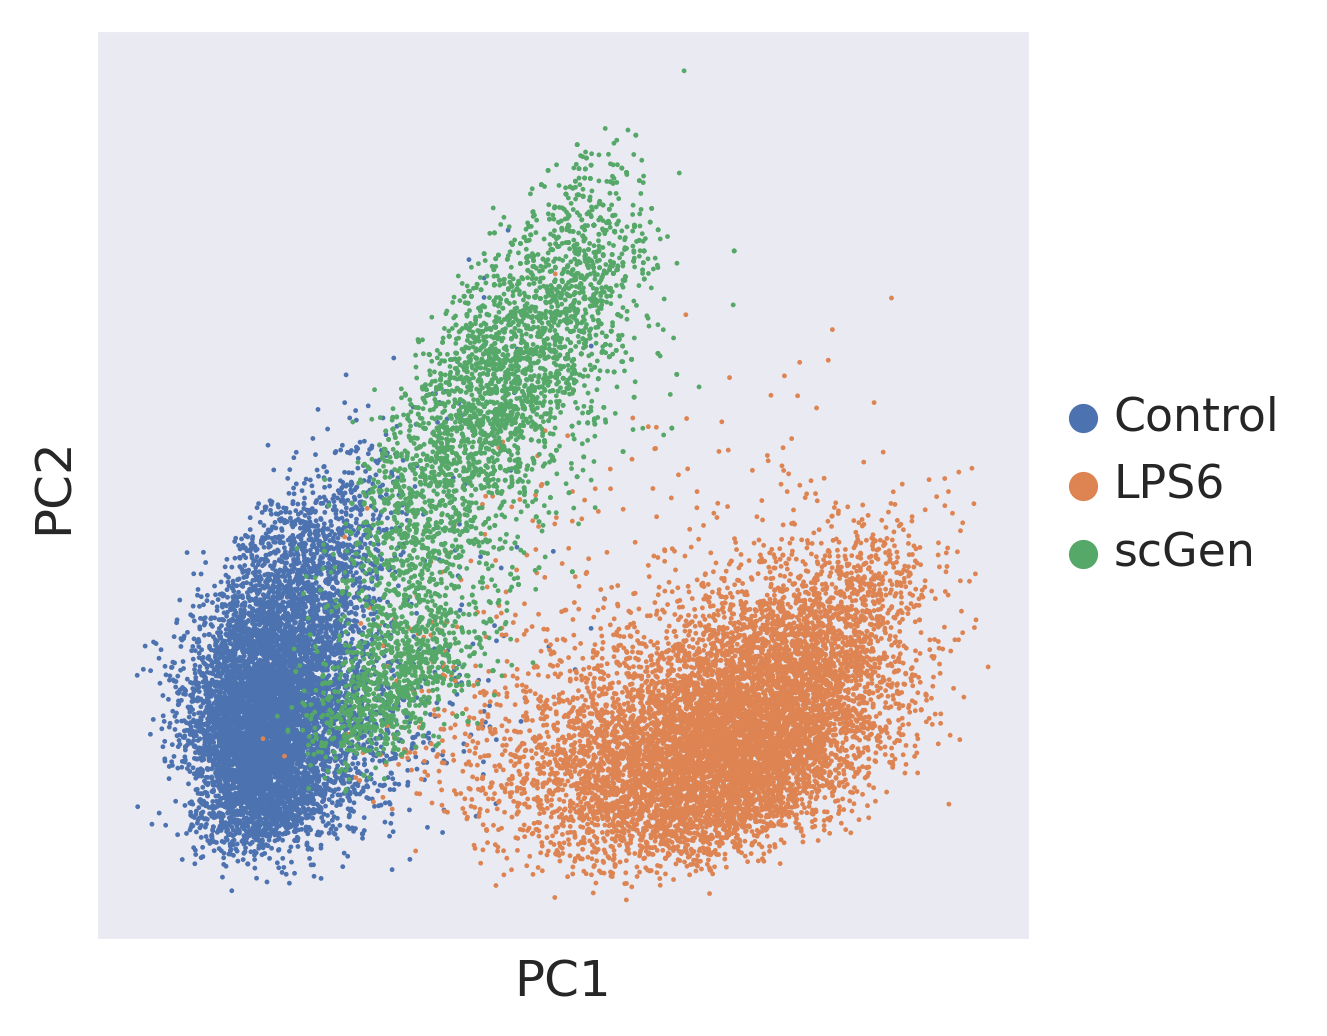

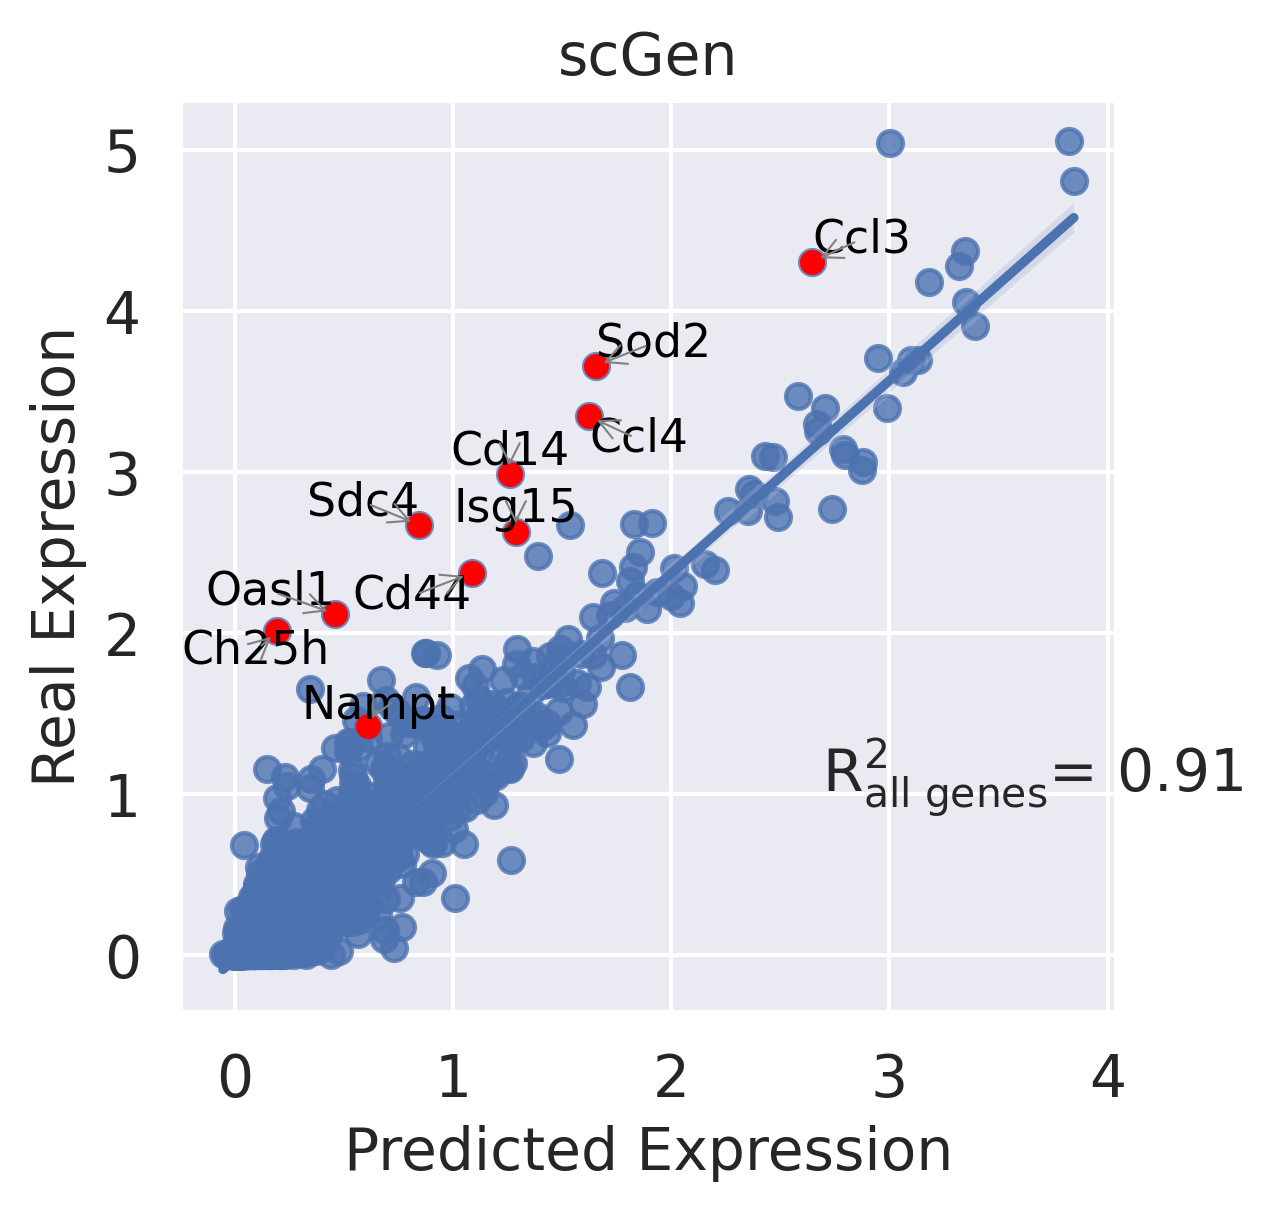

In [23]:
treat_pred = scgen_delta + latent_cd
predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
pred.obs["condition"] = 'pred'
ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata2.obs["condition"]:
    if i == 'unst':
        treatments.append("Control")
    elif i == "LPS6":
        treatments.append("LPS6")
    else:
        treatments.append("scGen")
eval_adata2.obs["Treatment"] = treatments
sc.tl.pca(eval_adata2)
sc.pl.pca(eval_adata2, color = "Treatment", frameon = True, title = "", save = "SF8B2.svg")
CD4T = adata[adata.obs["species"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["LPS6"]
r2_value = vae.reg_mean_plot(
eval_adata2,
axis_keys={"x": "pred", "y": "LPS6"},
gene_list=diff_genes[:10],
top_100_genes = None,
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF8C2.svg",
show=True,
legend=False, title = "scGen")

### scPreGAN Results

In [24]:
from scPreGAN import *

In [25]:
gan = Model(n_features=adata.X.shape[1], use_cuda=True)
train_data = gan.load_anndata(data_path="../data/train_species.h5ad",
            condition_key="condition",
            condition={"control":"unst", "case":"LPS6"},
            cell_type_key="species",
            out_of_sample_prediction = True,
            prediction_cell_type=cell
            )

Random Seed:  3060
Successfully created the model
Successfully loaded the model


In [12]:
# #Training scPreGan

# gan.train(train_data = train_data)

# torch.save(gan.D_A.state_dict(), "../data/gan_da_rat.pt")
# torch.save(gan.D_B.state_dict(), "../data/gan_db_rat.pt")
# torch.save(gan.G_A.state_dict(), "../data/gan_ga_rat.pt")
# torch.save(gan.G_B.state_dict(), "../data/gan_gb_rat.pt")
# torch.save(gan.E.state_dict(), "../data/gan_e_rat.pt")

[100/20000] adv_loss: -0.0238  recon_loss: 0.3465 encoding_loss: 0.0103 G_loss: 0.3330 D_A_loss: -108.1751  D_B_loss: -108.4284
[200/20000] adv_loss: -0.0382  recon_loss: 0.2965 encoding_loss: 0.0043 G_loss: 0.2626 D_A_loss: -93.5066  D_B_loss: -89.2510
[300/20000] adv_loss: -0.0352  recon_loss: 0.2698 encoding_loss: 0.0036 G_loss: 0.2381 D_A_loss: -84.6317  D_B_loss: -83.2130
[400/20000] adv_loss: -0.0327  recon_loss: 0.2668 encoding_loss: 0.0025 G_loss: 0.2366 D_A_loss: -78.1662  D_B_loss: -74.5129
[500/20000] adv_loss: -0.0302  recon_loss: 0.2525 encoding_loss: 0.0019 G_loss: 0.2242 D_A_loss: -73.4822  D_B_loss: -70.3501
[600/20000] adv_loss: -0.0206  recon_loss: 0.2416 encoding_loss: 0.0022 G_loss: 0.2232 D_A_loss: -69.2881  D_B_loss: -64.7405
[700/20000] adv_loss: -0.0243  recon_loss: 0.2421 encoding_loss: 0.0021 G_loss: 0.2200 D_A_loss: -63.4964  D_B_loss: -60.3896
[800/20000] adv_loss: -0.0142  recon_loss: 0.2307 encoding_loss: 0.0016 G_loss: 0.2180 D_A_loss: -58.9558  D_B_loss:

[6600/20000] adv_loss: 0.0538  recon_loss: 0.1740 encoding_loss: 0.0016 G_loss: 0.2294 D_A_loss: -12.9073  D_B_loss: -22.5973
[6700/20000] adv_loss: 0.0535  recon_loss: 0.1682 encoding_loss: 0.0012 G_loss: 0.2229 D_A_loss: -11.5948  D_B_loss: -22.3586
[6800/20000] adv_loss: 0.0605  recon_loss: 0.1753 encoding_loss: 0.0012 G_loss: 0.2370 D_A_loss: -11.5107  D_B_loss: -21.3939
[6900/20000] adv_loss: 0.0495  recon_loss: 0.1642 encoding_loss: 0.0016 G_loss: 0.2153 D_A_loss: -11.3190  D_B_loss: -21.5034
[7000/20000] adv_loss: 0.0492  recon_loss: 0.1729 encoding_loss: 0.0015 G_loss: 0.2236 D_A_loss: -10.7056  D_B_loss: -21.3990
[7100/20000] adv_loss: 0.0513  recon_loss: 0.1684 encoding_loss: 0.0015 G_loss: 0.2212 D_A_loss: -11.9519  D_B_loss: -21.0379
[7200/20000] adv_loss: 0.0475  recon_loss: 0.1684 encoding_loss: 0.0013 G_loss: 0.2172 D_A_loss: -11.7898  D_B_loss: -19.9595
[7300/20000] adv_loss: 0.0474  recon_loss: 0.1623 encoding_loss: 0.0016 G_loss: 0.2113 D_A_loss: -11.8793  D_B_loss: -

[13100/20000] adv_loss: 0.0239  recon_loss: 0.1691 encoding_loss: 0.0024 G_loss: 0.1954 D_A_loss: -11.4410  D_B_loss: -21.5614
[13200/20000] adv_loss: 0.0240  recon_loss: 0.1765 encoding_loss: 0.0018 G_loss: 0.2023 D_A_loss: -11.4681  D_B_loss: -21.7203
[13300/20000] adv_loss: 0.0243  recon_loss: 0.1790 encoding_loss: 0.0019 G_loss: 0.2052 D_A_loss: -11.7007  D_B_loss: -20.7988
[13400/20000] adv_loss: 0.0255  recon_loss: 0.1660 encoding_loss: 0.0023 G_loss: 0.1938 D_A_loss: -11.6956  D_B_loss: -20.8346
[13500/20000] adv_loss: 0.0250  recon_loss: 0.1715 encoding_loss: 0.0026 G_loss: 0.1991 D_A_loss: -12.8404  D_B_loss: -22.1297
[13600/20000] adv_loss: 0.0255  recon_loss: 0.1718 encoding_loss: 0.0028 G_loss: 0.2001 D_A_loss: -10.6984  D_B_loss: -21.0549
[13700/20000] adv_loss: 0.0253  recon_loss: 0.1679 encoding_loss: 0.0022 G_loss: 0.1955 D_A_loss: -11.5727  D_B_loss: -21.6037
[13800/20000] adv_loss: 0.0251  recon_loss: 0.1766 encoding_loss: 0.0022 G_loss: 0.2039 D_A_loss: -13.0105  D_B

[19600/20000] adv_loss: 0.0233  recon_loss: 0.1696 encoding_loss: 0.0031 G_loss: 0.1960 D_A_loss: -12.4942  D_B_loss: -20.7676
[19700/20000] adv_loss: 0.0235  recon_loss: 0.1716 encoding_loss: 0.0026 G_loss: 0.1976 D_A_loss: -12.1943  D_B_loss: -19.8476
[19800/20000] adv_loss: 0.0226  recon_loss: 0.1637 encoding_loss: 0.0026 G_loss: 0.1889 D_A_loss: -12.0065  D_B_loss: -19.6304
[19900/20000] adv_loss: 0.0239  recon_loss: 0.1671 encoding_loss: 0.0023 G_loss: 0.1933 D_A_loss: -12.6808  D_B_loss: -19.5891
[20000/20000] adv_loss: 0.0189  recon_loss: 0.1697 encoding_loss: 0.0018 G_loss: 0.1903 D_A_loss: -12.6852  D_B_loss: -19.4677
Training finished.


In [27]:
gan.D_A.load_state_dict(torch.load("../data/gan_da_rat.pt"))
gan.D_B.load_state_dict(torch.load("../data/gan_db_rat.pt"))
gan.G_A.load_state_dict(torch.load("../data/gan_ga_rat.pt"))
gan.G_B.load_state_dict(torch.load("../data/gan_gb_rat.pt"))
gan.G_B.load_state_dict(torch.load("../data/gan_gb_rat.pt"))
gan.E.load_state_dict(torch.load("../data/gan_e_rat.pt"))

<All keys matched successfully>

Predicting data finished


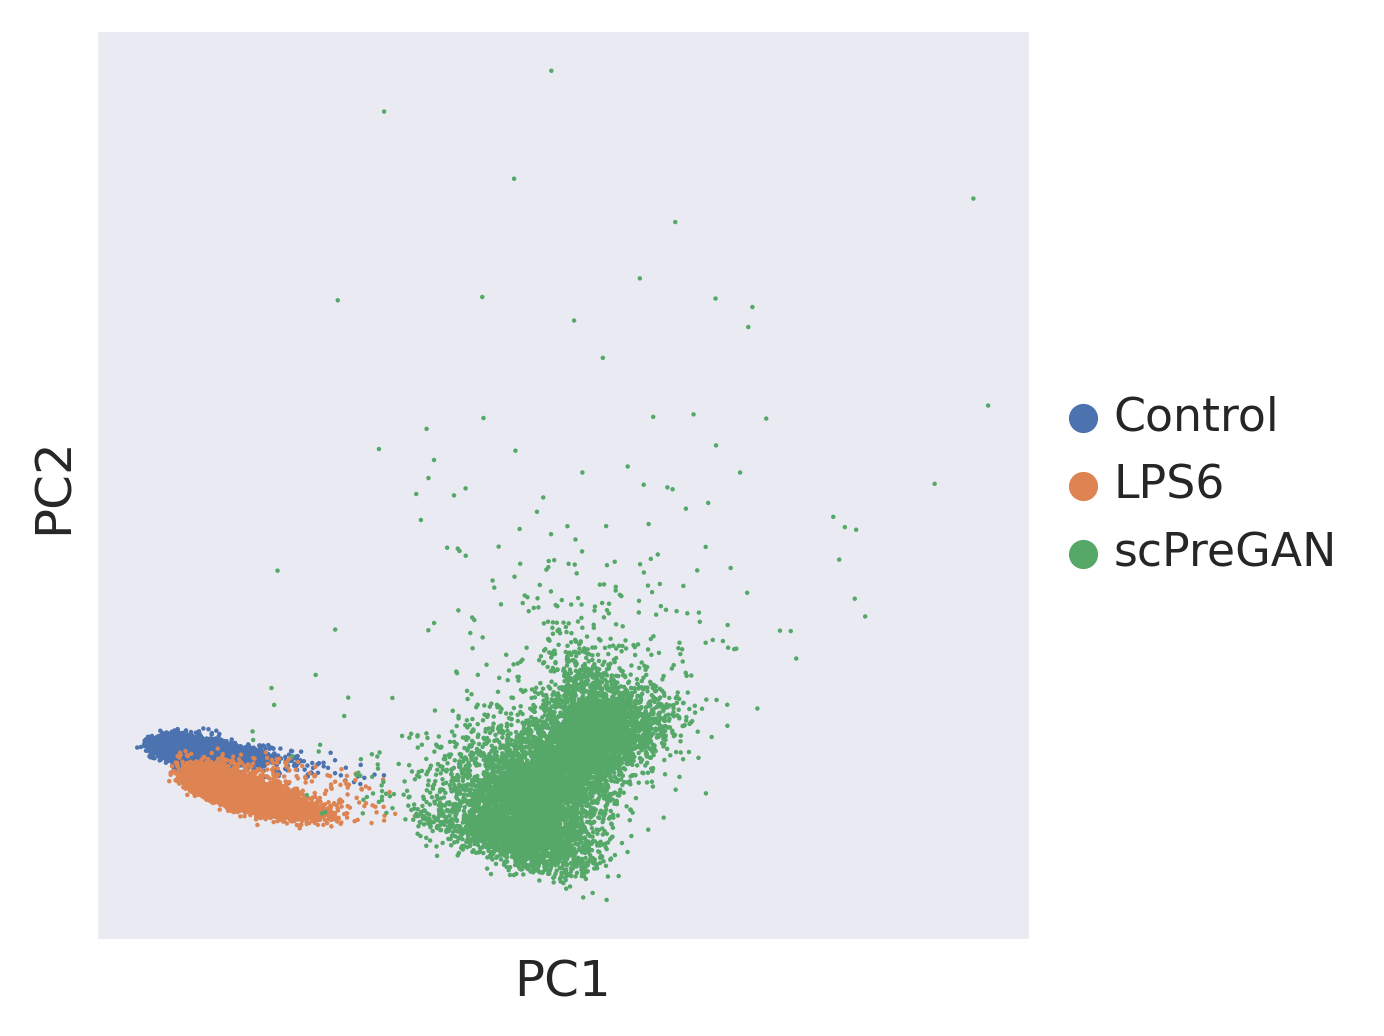

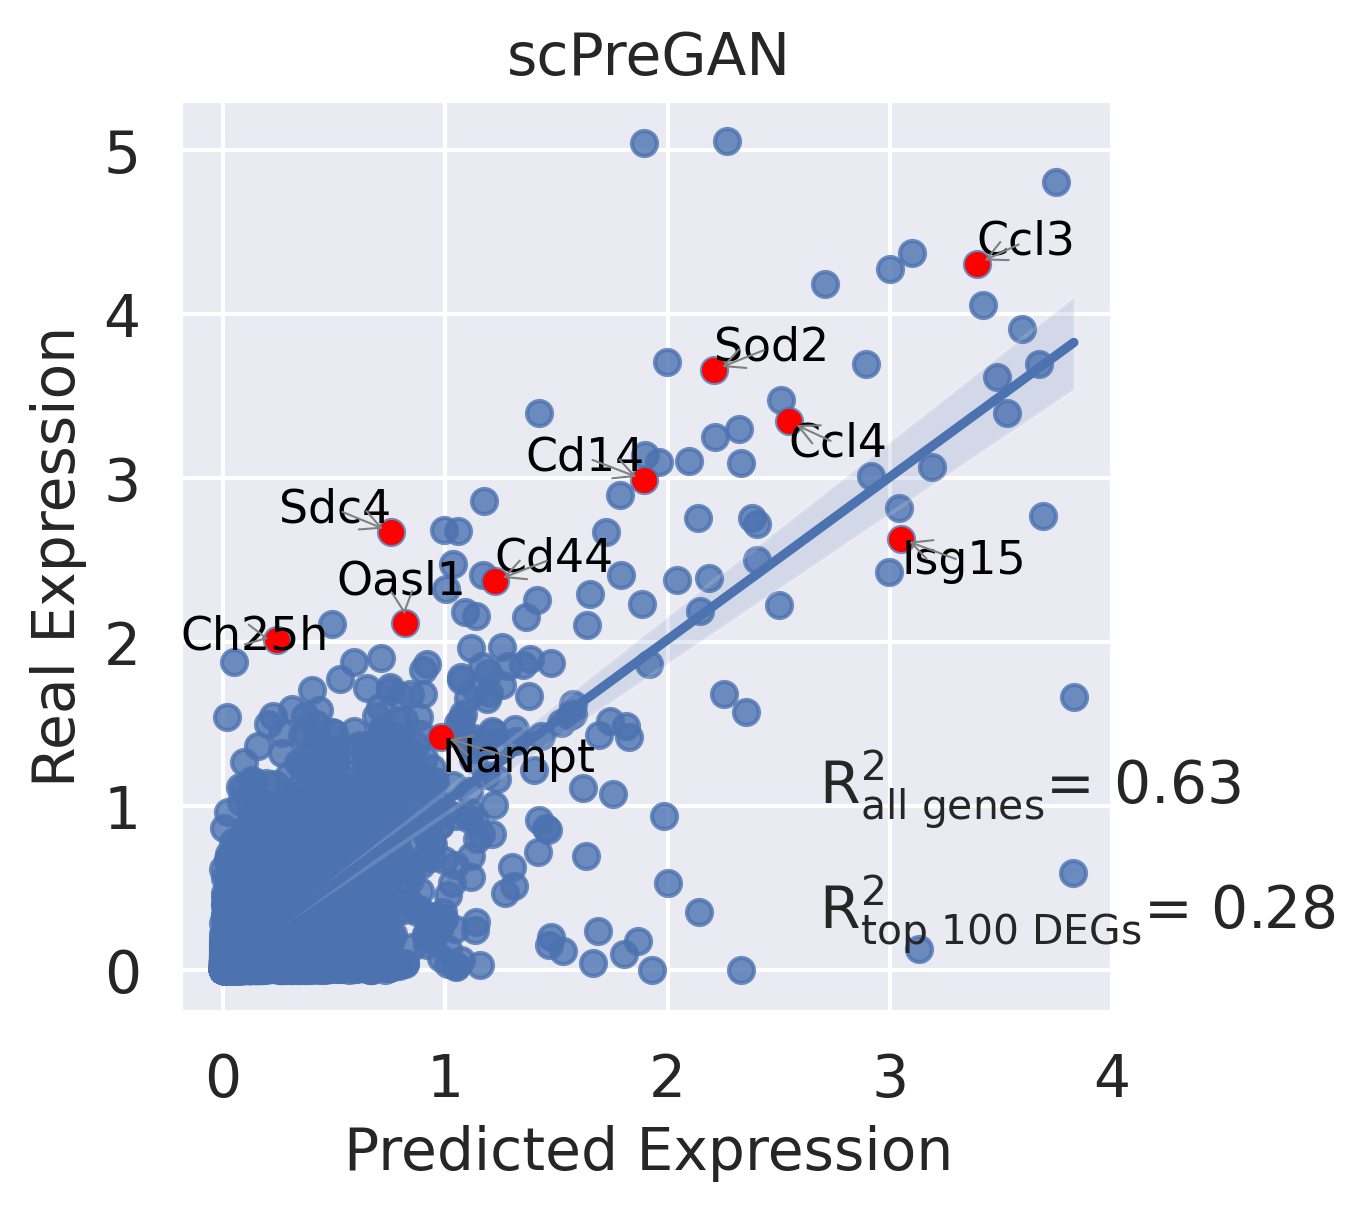

In [29]:
ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
pred = gan.predict(control_adata=ctrl_adata,
                   cell_type_key="species",
                   condition_key="condition")
pred.obs["condition"] = 'pred'
treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
eval_adata3 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata3.obs["condition"]:
    if i == 'unst':
        treatments.append("Control")
    elif i == "LPS6":
        treatments.append("LPS6")
    else:
        treatments.append("scPreGAN")
eval_adata3.obs["Treatment"] = treatments
sc.tl.pca(eval_adata3)
sc.pl.pca(eval_adata3, color = "Treatment", frameon = True, title = "", save = "SF8B3.svg")
CD4T = adata[adata.obs["species"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["LPS6"]
r2_value = vae.reg_mean_plot(
eval_adata3,
axis_keys={"x": "pred", "y": "LPS6"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF8C3.svg",
show=True,
legend=False, title = "scPreGAN")

### CellOT Prediction

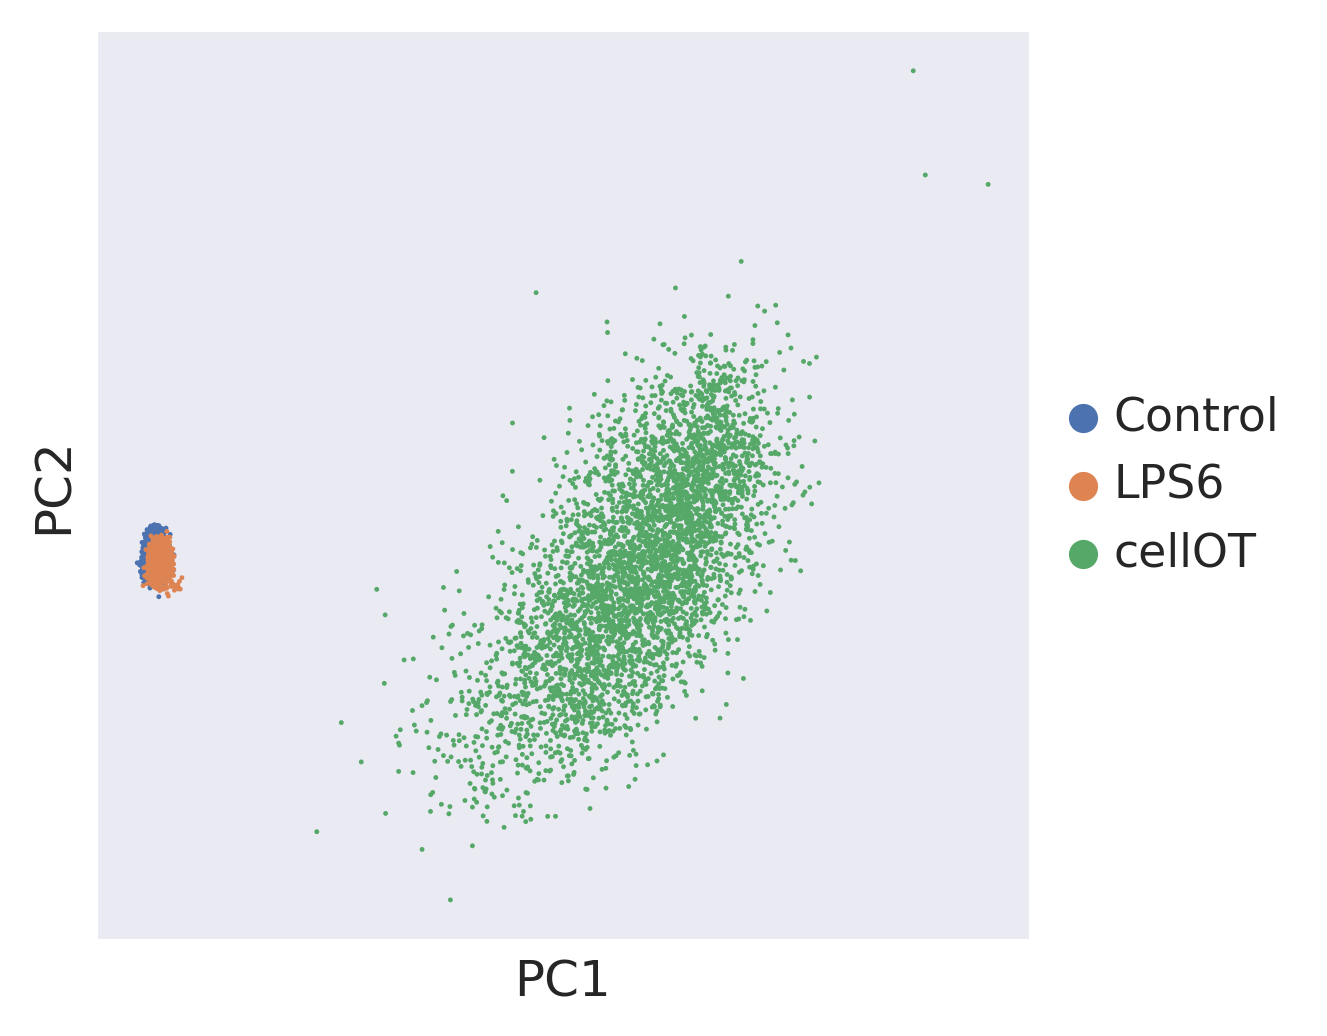

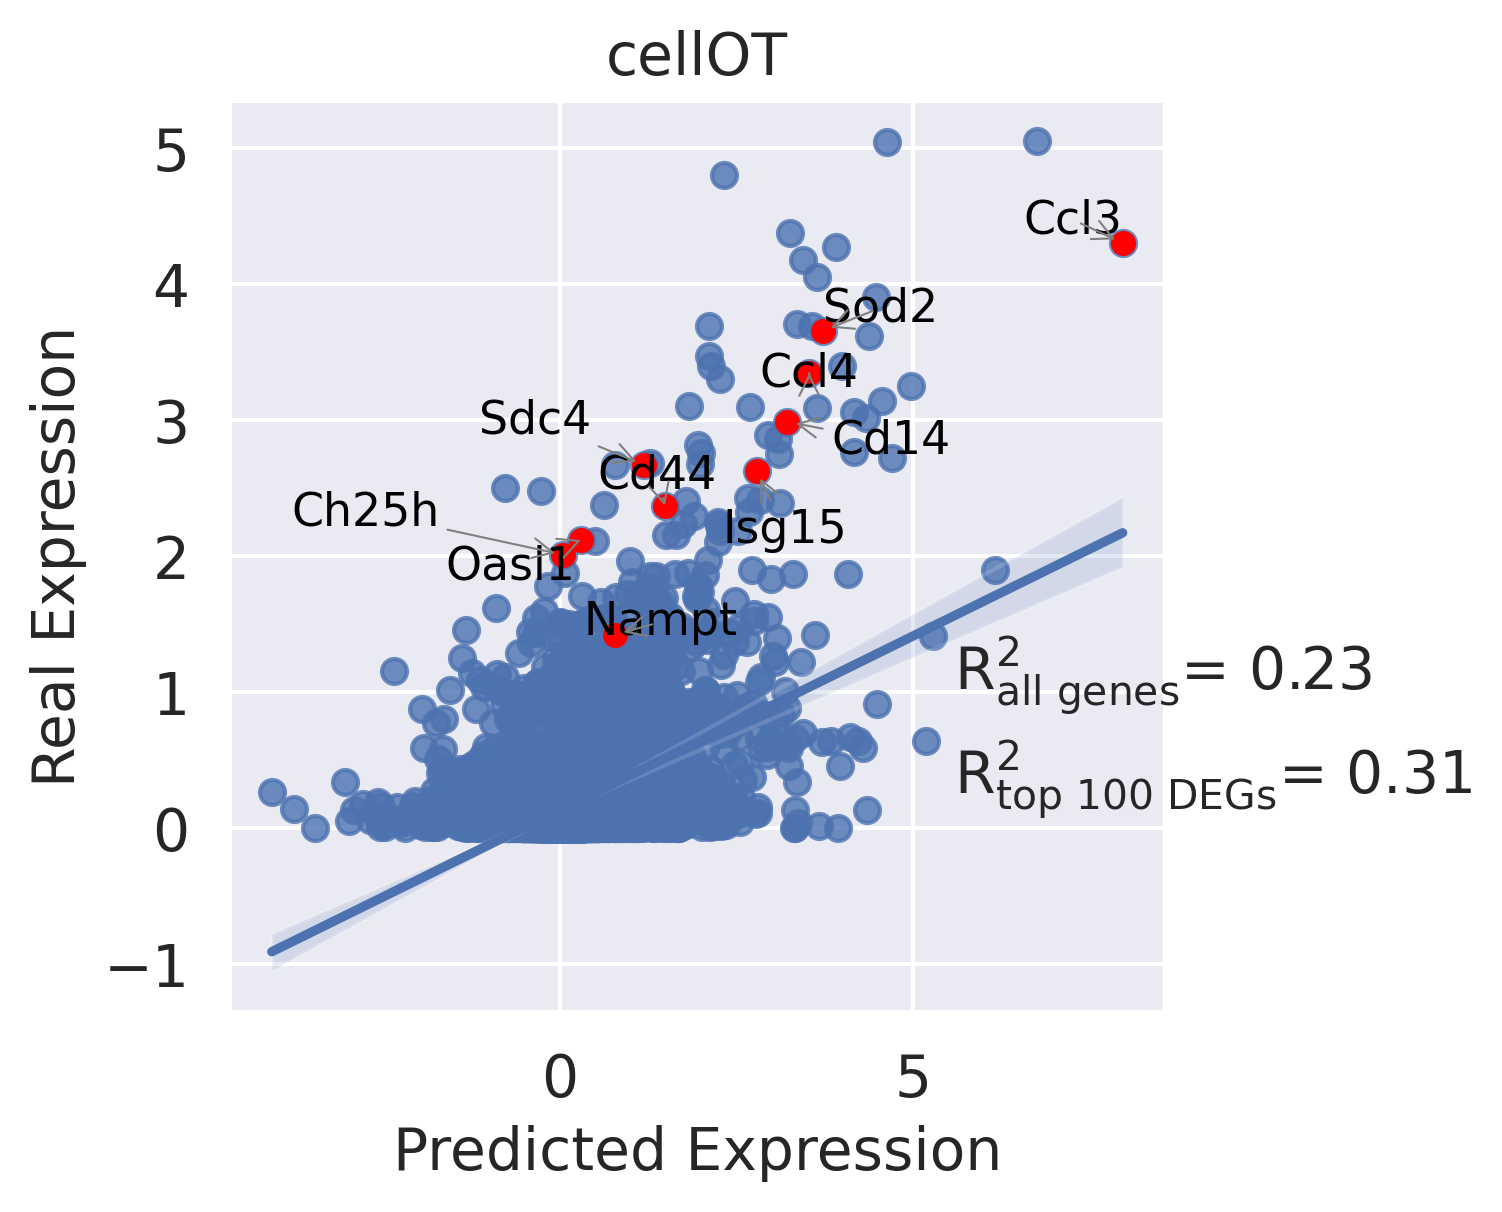

In [15]:
cellot_dir = "../data/cellot-pred"
pred = sc.read_h5ad(f"{cellot_dir}/holdout-rat/model-cellot/evals_ood_data_space/imputed.h5ad")
pred.obs["condition"] = 'pred'
ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]

eval_adata4 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata4.obs["condition"]:
    if i == 'unst':
        treatments.append("Control")
    elif i == "LPS6":
        treatments.append("LPS6")
    else:
        treatments.append("cellOT")
eval_adata4.obs["Treatment"] = treatments
sc.tl.pca(eval_adata4)
sc.pl.pca(eval_adata4, color = "Treatment", frameon = True, title = "", save = "SF8B3.svg")
CD4T = adata[adata.obs["species"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["LPS6"]
r2_value = vae.reg_mean_plot(
eval_adata4,
axis_keys={"x": "pred", "y": "LPS6"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF8C3.svg",
show=True,
legend=False, title = "cellOT")

# Supplementary Figure 8C

In [135]:
# df_list = []
# for cell in ["rat", "rabbit", "pig"]:
#     print(cell)
#     train_adata, test_adata = prepare_data(adata, "species", "condition", cell, "LPS6", normalized = True)

#     vae = VIDR(train_adata, linear_decoder = False)
# #     vae.train(
# #     max_epochs=100,
# #     batch_size=128,
# #     early_stopping=True,
# #     early_stopping_patience=25)
    
# #     vae.save(f"../../data/VAE_Binary_Prediction_IFNB_7000g_{cell}.pt")
#     vae = vae.load(f"../../data/VAE_Species_Prediction_LPS_7000g_{cell}.pt/", train_adata)
    
#     vae_name = "scGen"
    
#     ctrl_key = "unst"
#     treat_key = "LPS6"
    
#     cell_type_to_predict = cell
#     cell_type_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_labels"][
#         "original_key"
#     ]
#     treatment_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_batch"][
#         "original_key"
#     ]
    
#     vae.adata.obs["species_condition"] = adata.obs.species.astype(str) + adata.obs.condition.astype(str)
    
#     adata_bal = random_sample(vae.adata, "species_condition", "min")
#     adata_bal_ctrl = adata_bal[(adata_bal.obs[cell_type_key] == cell_type_to_predict) & (adata_bal.obs[treatment_key] == ctrl_key)]
#     latent_bal =  vae.get_latent_representation(adata_bal)
#     latent_bal_adata = sc.AnnData(X=latent_bal, obs = adata_bal.obs.copy())
#     latent_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_type_to_predict) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X

#     latent_mouse_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == "mouse") & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
#     latent_mouse_trt = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == "mouse") & (latent_bal_adata.obs[treatment_key] == treat_key)].X

#     scgen_treat_delta = np.average(latent_mouse_trt,axis=0) - np.average(latent_mouse_cd,axis=0)
#     scgen_species_delta = np.average(latent_cd,axis=0) - np.average(latent_mouse_cd,axis=0)
    
#     treat_pred = 0.5*(scgen_species_delta + latent_mouse_trt + scgen_treat_delta + latent_cd)
#     predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
#     pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
    
    
#     pred.obs["condition"] = 'pred'
#     ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
#     treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
#     eval_adata = ctrl_adata.concatenate(treat_adata, pred)
    
#     CD4T = adata[adata.obs["species"] ==cell]
#     sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
#     diff_genes = CD4T.uns["rank_genes_groups"]["names"][treat_key]
    
#     r2_df = calculate_r2_singledose(
#         eval_adata, cell,
#         vae_name, 
#         "condition", 
#         {"x":"pred", "y":"LPS6"}, 
#         diff_genes=None, 
#         random_sample_coef = 0.8,
#         n_iter = 100
#     )
#     df_list.append(r2_df)

rat
INFO     Using batches from adata.obs["condition"]                                                                 
INFO     Using labels from adata.obs["species"]                                                                    
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 52691 cells, 6619 vars, 2 batches, 4 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
None
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                

In [136]:
# for cell in ["rat", "rabbit", "pig"]:
#     print(cell)
#     train_adata, test_adata = prepare_data(adata, "species", "condition", cell, "LPS6", normalized = True)

#     vae = VIDR(train_adata, linear_decoder = False)
# #     vae.train(
# #     max_epochs=100,
# #     batch_size=128,
# #     early_stopping=True,
# #     early_stopping_patience=25)
    
# #     vae.save(f"../../data/VAE_Binary_Prediction_IFNB_7000g_{cell}.pt")
#     vae = vae.load(f"../../data/VAE_Species_Prediction_LPS_7000g_{cell}.pt/", train_adata)
    
#     vae_name = "scVIDR"
    
#     ctrl_key = "unst"
#     treat_key = "LPS6"

#     cell_type_to_predict = cell
#     cell_type_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_labels"][
#         "original_key"
#     ]
#     treatment_key = vae.scvi_setup_dict_["categorical_mappings"]["_scvi_batch"][
#         "original_key"
#     ]
    
#     vae.adata.obs["species_condition"] = adata.obs.species.astype(str) + adata.obs.condition.astype(str)
    
#     adata_bal = random_sample(vae.adata, "species_condition", "min")
#     adata_bal_ctrl = adata_bal[(adata_bal.obs[cell_type_key] == cell_type_to_predict) & (adata_bal.obs[treatment_key] == ctrl_key)]
#     latent_bal =  vae.get_latent_representation(adata_bal)
#     latent_bal_adata = sc.AnnData(X=latent_bal, obs = adata_bal.obs.copy())
#     latent_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_type_to_predict) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
    
#     #Get deltas and control centroids for each cell tpye in the training dataset
#     deltas = []
#     latent_centroids = []
#     cell_types = np.unique(latent_bal_adata.obs[cell_type_key])
#     for cell_i in cell_types:
#         if cell_i != cell_type_to_predict:
#             latent_ctrl = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
#             latent_treat = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == treat_key)].X
#             deltas_i = np.average(latent_treat, axis = 0) - np.average(latent_ctrl, axis = 0)
#             deltas.append(deltas_i)
#             latent_centroids.append(np.average(latent_ctrl, axis = 0))
#     lr = LinearRegression()
#     reg = lr.fit(latent_centroids, deltas)
#     scvidr_delta = reg.predict([np.average(latent_cd, axis = 0)])[0]
    
#     treat_pred = scvidr_delta + latent_cd
#     predicted_cells = vae.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
#     pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
    
#     pred.obs["condition"] = 'pred'
#     ctrl_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "unst"))]
#     treat_adata = adata[((adata.obs['species'] == cell) & (adata.obs["condition"] == "LPS6"))]
#     eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
    
#     CD4T = adata[adata.obs["species"] ==cell]
#     sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
#     diff_genes = CD4T.uns["rank_genes_groups"]["names"][treat_key]
    
#     r2_df = calculate_r2_singledose(
#         eval_adata2, cell,
#         vae_name, 
#         "condition", 
#         {"x":"pred", "y":treat_key}, 
#         diff_genes=None, 
#         random_sample_coef = 0.8,
#         n_iter = 100
#     )
#     df_list.append(r2_df)

rat
INFO     Using batches from adata.obs["condition"]                                                                 
INFO     Using labels from adata.obs["species"]                                                                    
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 52691 cells, 6619 vars, 2 batches, 4 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
None
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                

In [137]:
# r2_values_allCells_df = pd.concat(df_list)

In [138]:
# r2_values_allCells_df.to_csv("../data/Species_Model_Results.csv")

In [139]:
# r2_values_allCells_df = pd.read_csv("../data/Species_Model_Results.csv")

In [149]:
# r2_df_hvgs = r2_values_allCells_df[r2_values_allCells_df["Gene Set"] == "All HVGs"]

In [ ]:
# r2_df_hvgs = r2_values_allCells_df[r2_values_allCells_df["Gene Set"] == "All HVGs"]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

scVIDR_pig vs. scGen_pig: Mann-Whitney-Wilcoxon test greater, P_val:1.000e+00 U_stat=0.000e+00
scVIDR_rat vs. scGen_rat: Mann-Whitney-Wilcoxon test greater, P_val:1.281e-34 U_stat=1.000e+04
scVIDR_rabbit vs. scGen_rabbit: Mann-Whitney-Wilcoxon test greater, P_val:1.281e-34 U_stat=1.000e+04


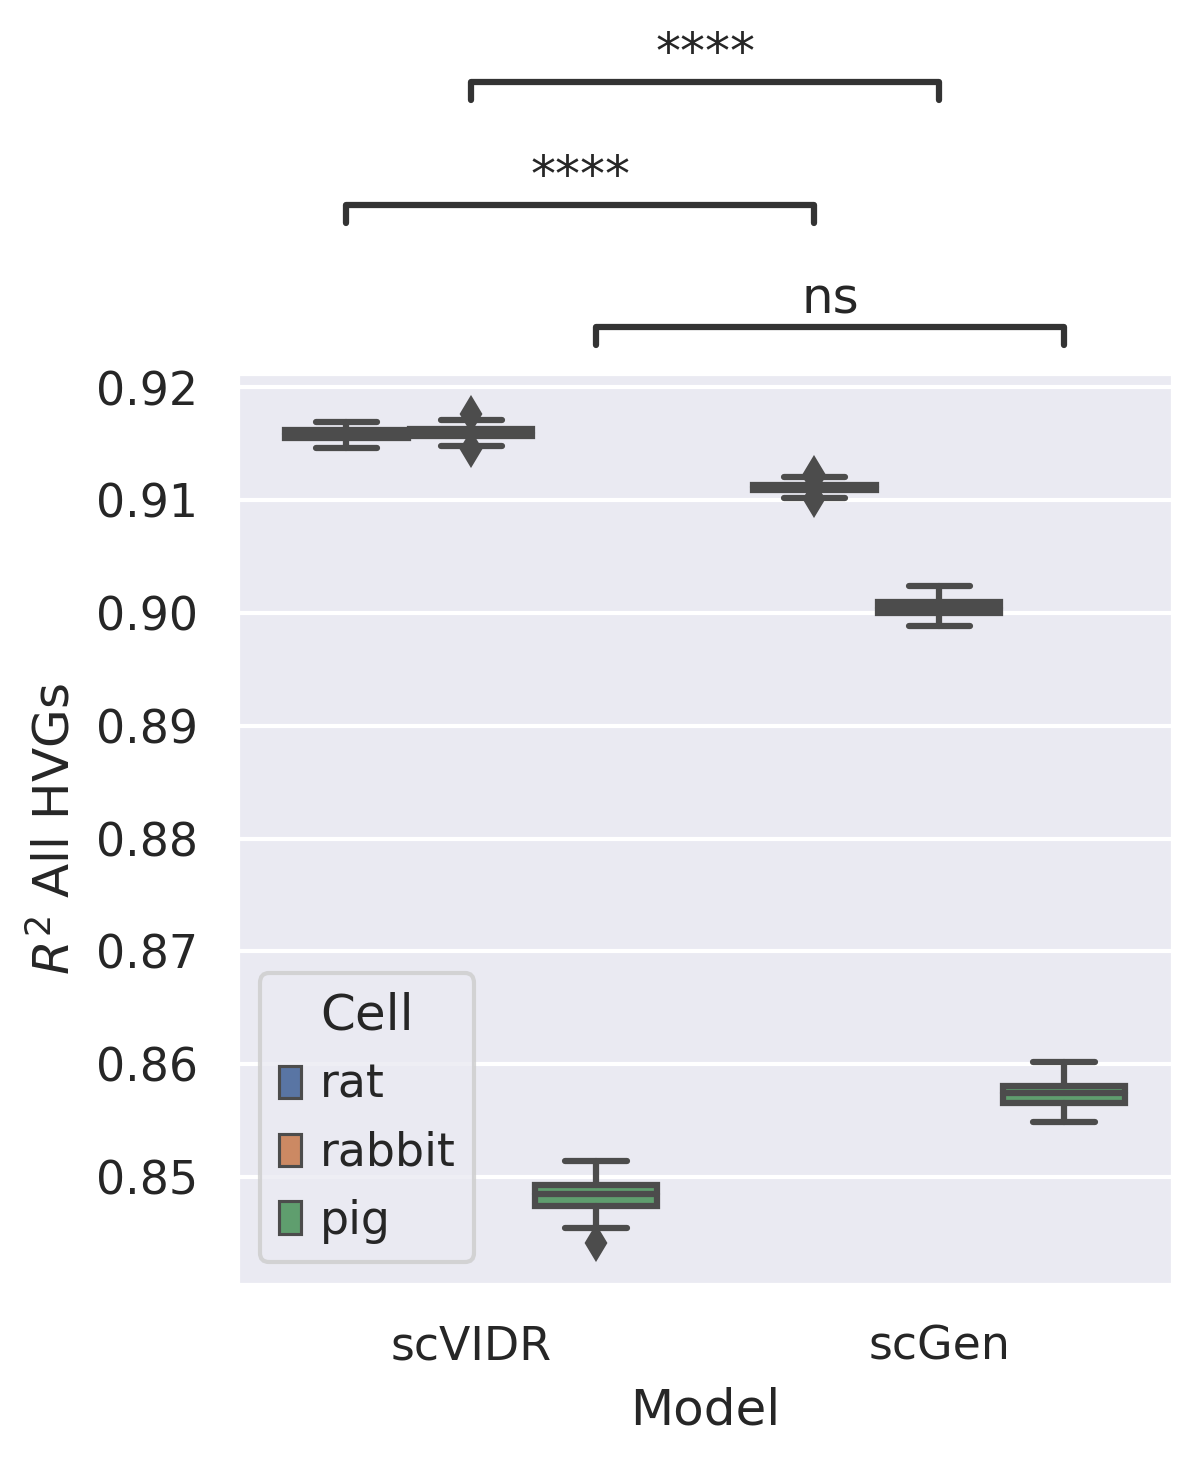

In [154]:
# order = ['scVIDR', 'scGen',]# 'scPreGAN', "CellOT"]
# hue_order = ["rat", "rabbit", "pig"]
# ax = sns.boxplot(x = "Model", y = "R^2",  data = r2_df_hvgs, hue = "Cell", order = order, hue_order = hue_order)
# pairs = [
#     (('scVIDR','rat'), ('scGen', 'rat')),
#     (('scVIDR', 'rabbit'), ('scGen', 'rabbit')),
#     (('scVIDR', 'pig'), ('scGen', 'pig'))
# #    (('scVIDR','All HVGs'), ('scPreGAN', 'All HVGs')),
# #    (('scVIDR','DEGs'), ('scPreGAN', 'DEGs')),
# #    (('scVIDR', 'All HVGs'), ('CellOT', 'All HVGs')),
# #    (('scVIDR', 'DEGs'), ('CellOT', 'DEGs'))
# ]
# annotator = Annotator(ax, pairs, data=r2_df_hvgs, x="Model", y="R^2", hue = "Cell", order = order)
# annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
# annotator.apply_and_annotate()
# plt.ylabel(r"$R^2$ All HVGs")
# plt.savefig("../figures/SF8D.svg", bbox_inches = "tight")
# plt.show()

In [156]:
# r2_df_degs = r2_values_allCells_df[r2_values_allCells_df["Gene Set"] == "DEGs"]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

scVIDR_pig vs. scGen_pig: Mann-Whitney-Wilcoxon test greater, P_val:1.000e+00 U_stat=0.000e+00
scVIDR_rat vs. scGen_rat: Mann-Whitney-Wilcoxon test greater, P_val:1.281e-34 U_stat=1.000e+04
scVIDR_rabbit vs. scGen_rabbit: Mann-Whitney-Wilcoxon test greater, P_val:1.000e+00 U_stat=0.000e+00


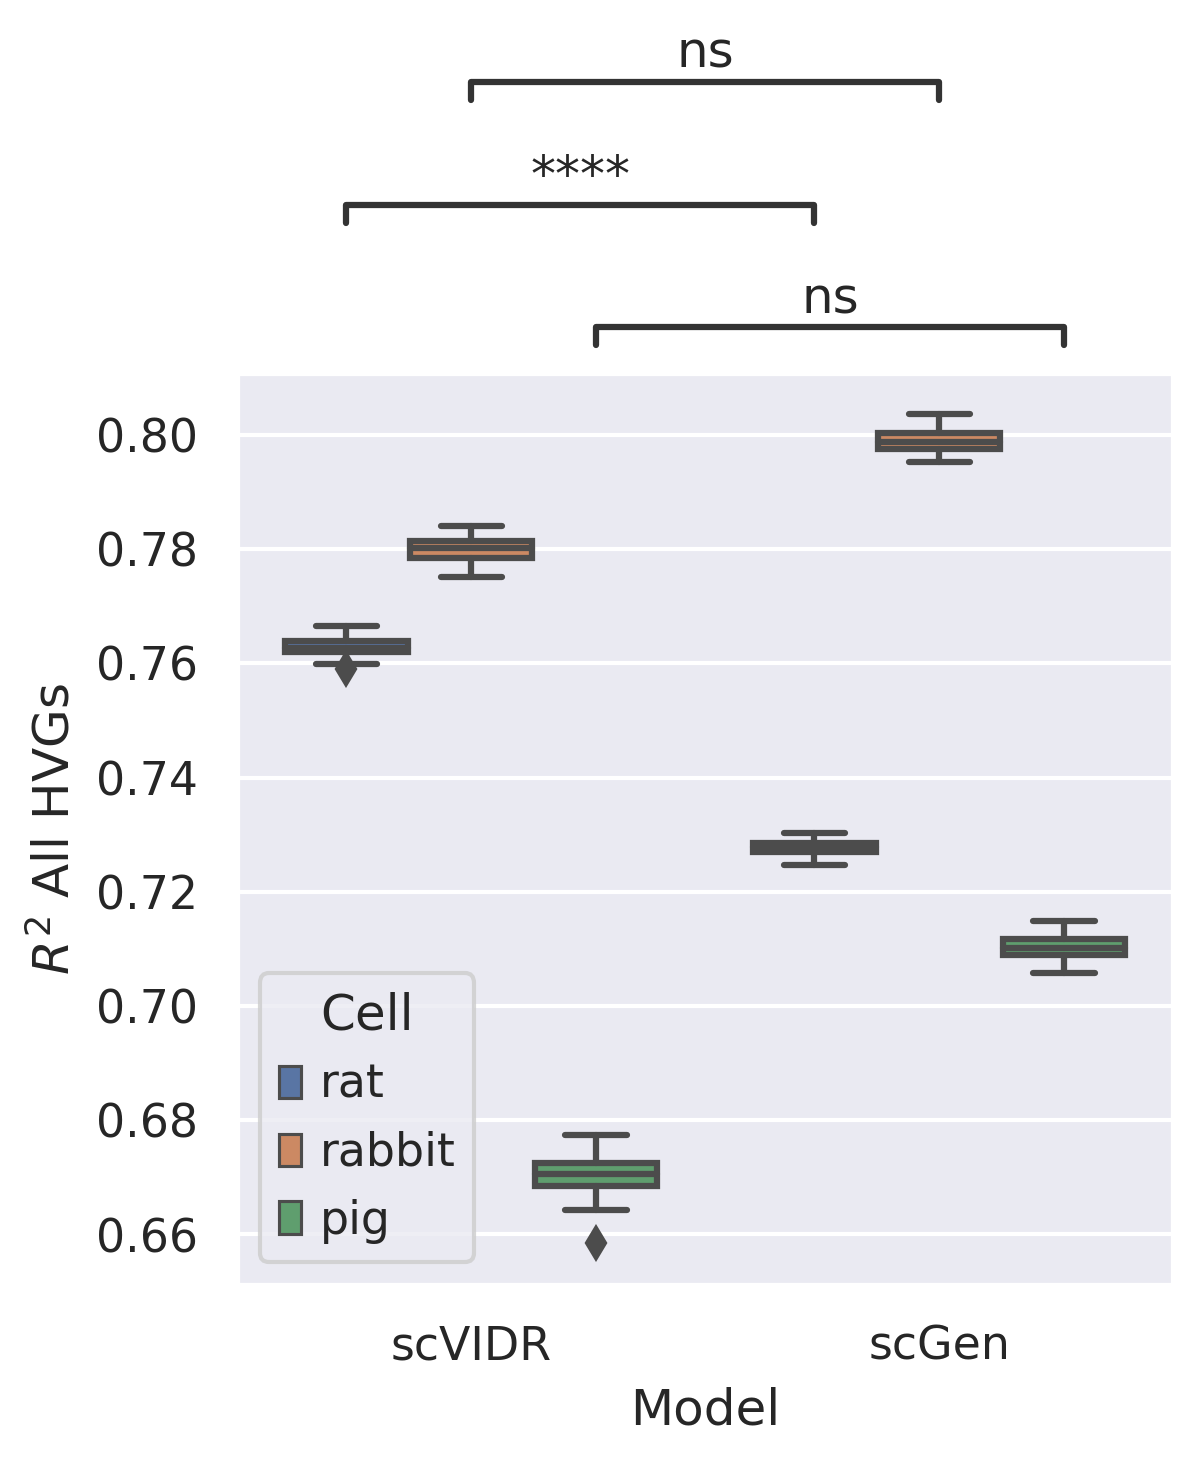

In [157]:
# order = ['scVIDR', 'scGen',]# 'scPreGAN', "CellOT"]
# hue_order = ["rat", "rabbit", "pig"]
# ax = sns.boxplot(x = "Model", y = "R^2",  data = r2_df_degs, hue = "Cell", order = order, hue_order = hue_order)
# pairs = [
#     (('scVIDR','rat'), ('scGen', 'rat')),
#     (('scVIDR', 'rabbit'), ('scGen', 'rabbit')),
#     (('scVIDR', 'pig'), ('scGen', 'pig'))
# #    (('scVIDR','All HVGs'), ('scPreGAN', 'All HVGs')),
# #    (('scVIDR','DEGs'), ('scPreGAN', 'DEGs')),
# #    (('scVIDR', 'All HVGs'), ('CellOT', 'All HVGs')),
# #    (('scVIDR', 'DEGs'), ('CellOT', 'DEGs'))
# ]
# annotator = Annotator(ax, pairs, data=r2_df_degs, x="Model", y="R^2", hue = "Cell", order = order)
# annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
# annotator.apply_and_annotate()
# plt.ylabel(r"$R^2$ All HVGs")
# plt.savefig("../figures/SF8D.svg", bbox_inches = "tight")
# plt.show()